# Анализ датасета

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

In [85]:
addr_to_addr_df = pd.read_csv("./dataset/Elliptic++ Dataset/AddrAddr_edgelist.csv")

In [2]:
addr_to_tx_df = pd.read_csv("./dataset/Elliptic++ Dataset/AddrTx_edgelist.csv")

In [5]:
tx_to_inc_cnt = addr_to_tx_df \
    .groupby("txId") \
    .agg({
        "input_address": "nunique",
    }) \
    .reset_index() \
    .rename(columns={
        "input_address": "incoming_addr_cnt",
    })
tx_to_inc_cnt["incoming_addr_cnt"].value_counts()


incoming_addr_cnt
1      159297
2       22479
3        6436
4        3534
5        2202
        ...  
510         1
624         1
452         1
177         1
285         1
Name: count, Length: 300, dtype: int64

In [6]:
tx_to_inc_cnt.shape

(202804, 2)

## Поиск числа соседей для каждого адреса

In [86]:
actor_to_outcoming_neighbour_cnt = addr_to_addr_df \
    .groupby("input_address") \
    .agg({
        "output_address": "nunique",
    }) \
    .reset_index() \
    .rename(columns={
        "input_address": "actor_id",
        "output_address": "outcoming_neighbors_cnt",
    })
actor_to_incoming_neighbour_cnt = addr_to_addr_df \
    .groupby("output_address") \
    .agg({
        "input_address": "nunique",
    }) \
    .reset_index() \
    .rename(columns={
        "output_address": "actor_id",
        "input_address": "incoming_neighbors_cnt",
    })

actor_to_nei_joined = pd.merge(
    actor_to_outcoming_neighbour_cnt,
    actor_to_incoming_neighbour_cnt,
    on="actor_id",
    how="outer"
)
actor_to_nei_joined["incoming_neighbors_cnt"] = actor_to_nei_joined["incoming_neighbors_cnt"].fillna(0)
actor_to_nei_joined["outcoming_neighbors_cnt"] = actor_to_nei_joined["outcoming_neighbors_cnt"].fillna(0)

actor_to_neighbour_cnt = actor_to_nei_joined
actor_to_neighbour_cnt["neighbors_cnt"] = actor_to_neighbour_cnt["incoming_neighbors_cnt"] + actor_to_neighbour_cnt["outcoming_neighbors_cnt"]

actor_to_neighbour_cnt.head()

,actor_id,outcoming_neighbors_cnt,incoming_neighbors_cnt,neighbors_cnt
0,111112TykSw72ztDN2WJger4cynzWYC5w,0.0,24.0,24.0
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,0.0,8.0,8.0
2,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,0.0,1.0,1.0
3,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,2.0,2.0,4.0
4,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,0.0,5.0,5.0


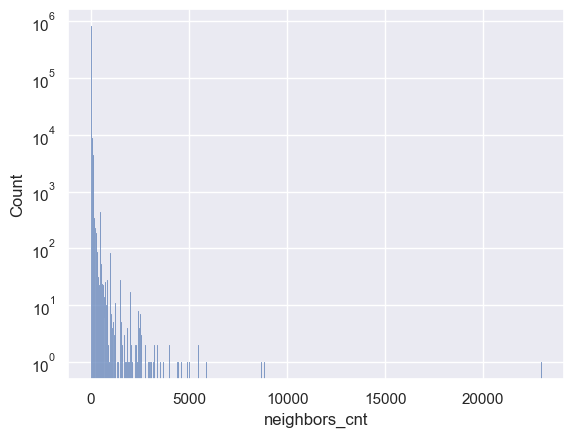

In [87]:
sns.histplot(
    data=actor_to_neighbour_cnt,
    x="neighbors_cnt",
    bins=500
)
plt.yscale("log")

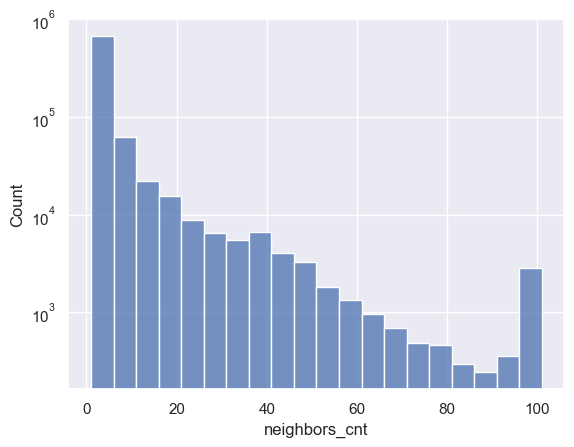

In [88]:
quantile_99 = actor_to_neighbour_cnt["neighbors_cnt"].quantile(0.99)
quantile_995 = actor_to_neighbour_cnt["neighbors_cnt"].quantile(0.995)

sns.histplot(
    data=actor_to_neighbour_cnt[actor_to_neighbour_cnt["neighbors_cnt"] <= quantile_995],
    x="neighbors_cnt",
    bins=20
)
plt.yscale("log")

Выделим подозрительных пользователей - с количеством транзакций > 99 квантиля

<Axes: xlabel='count', ylabel='neighbors_cnt'>

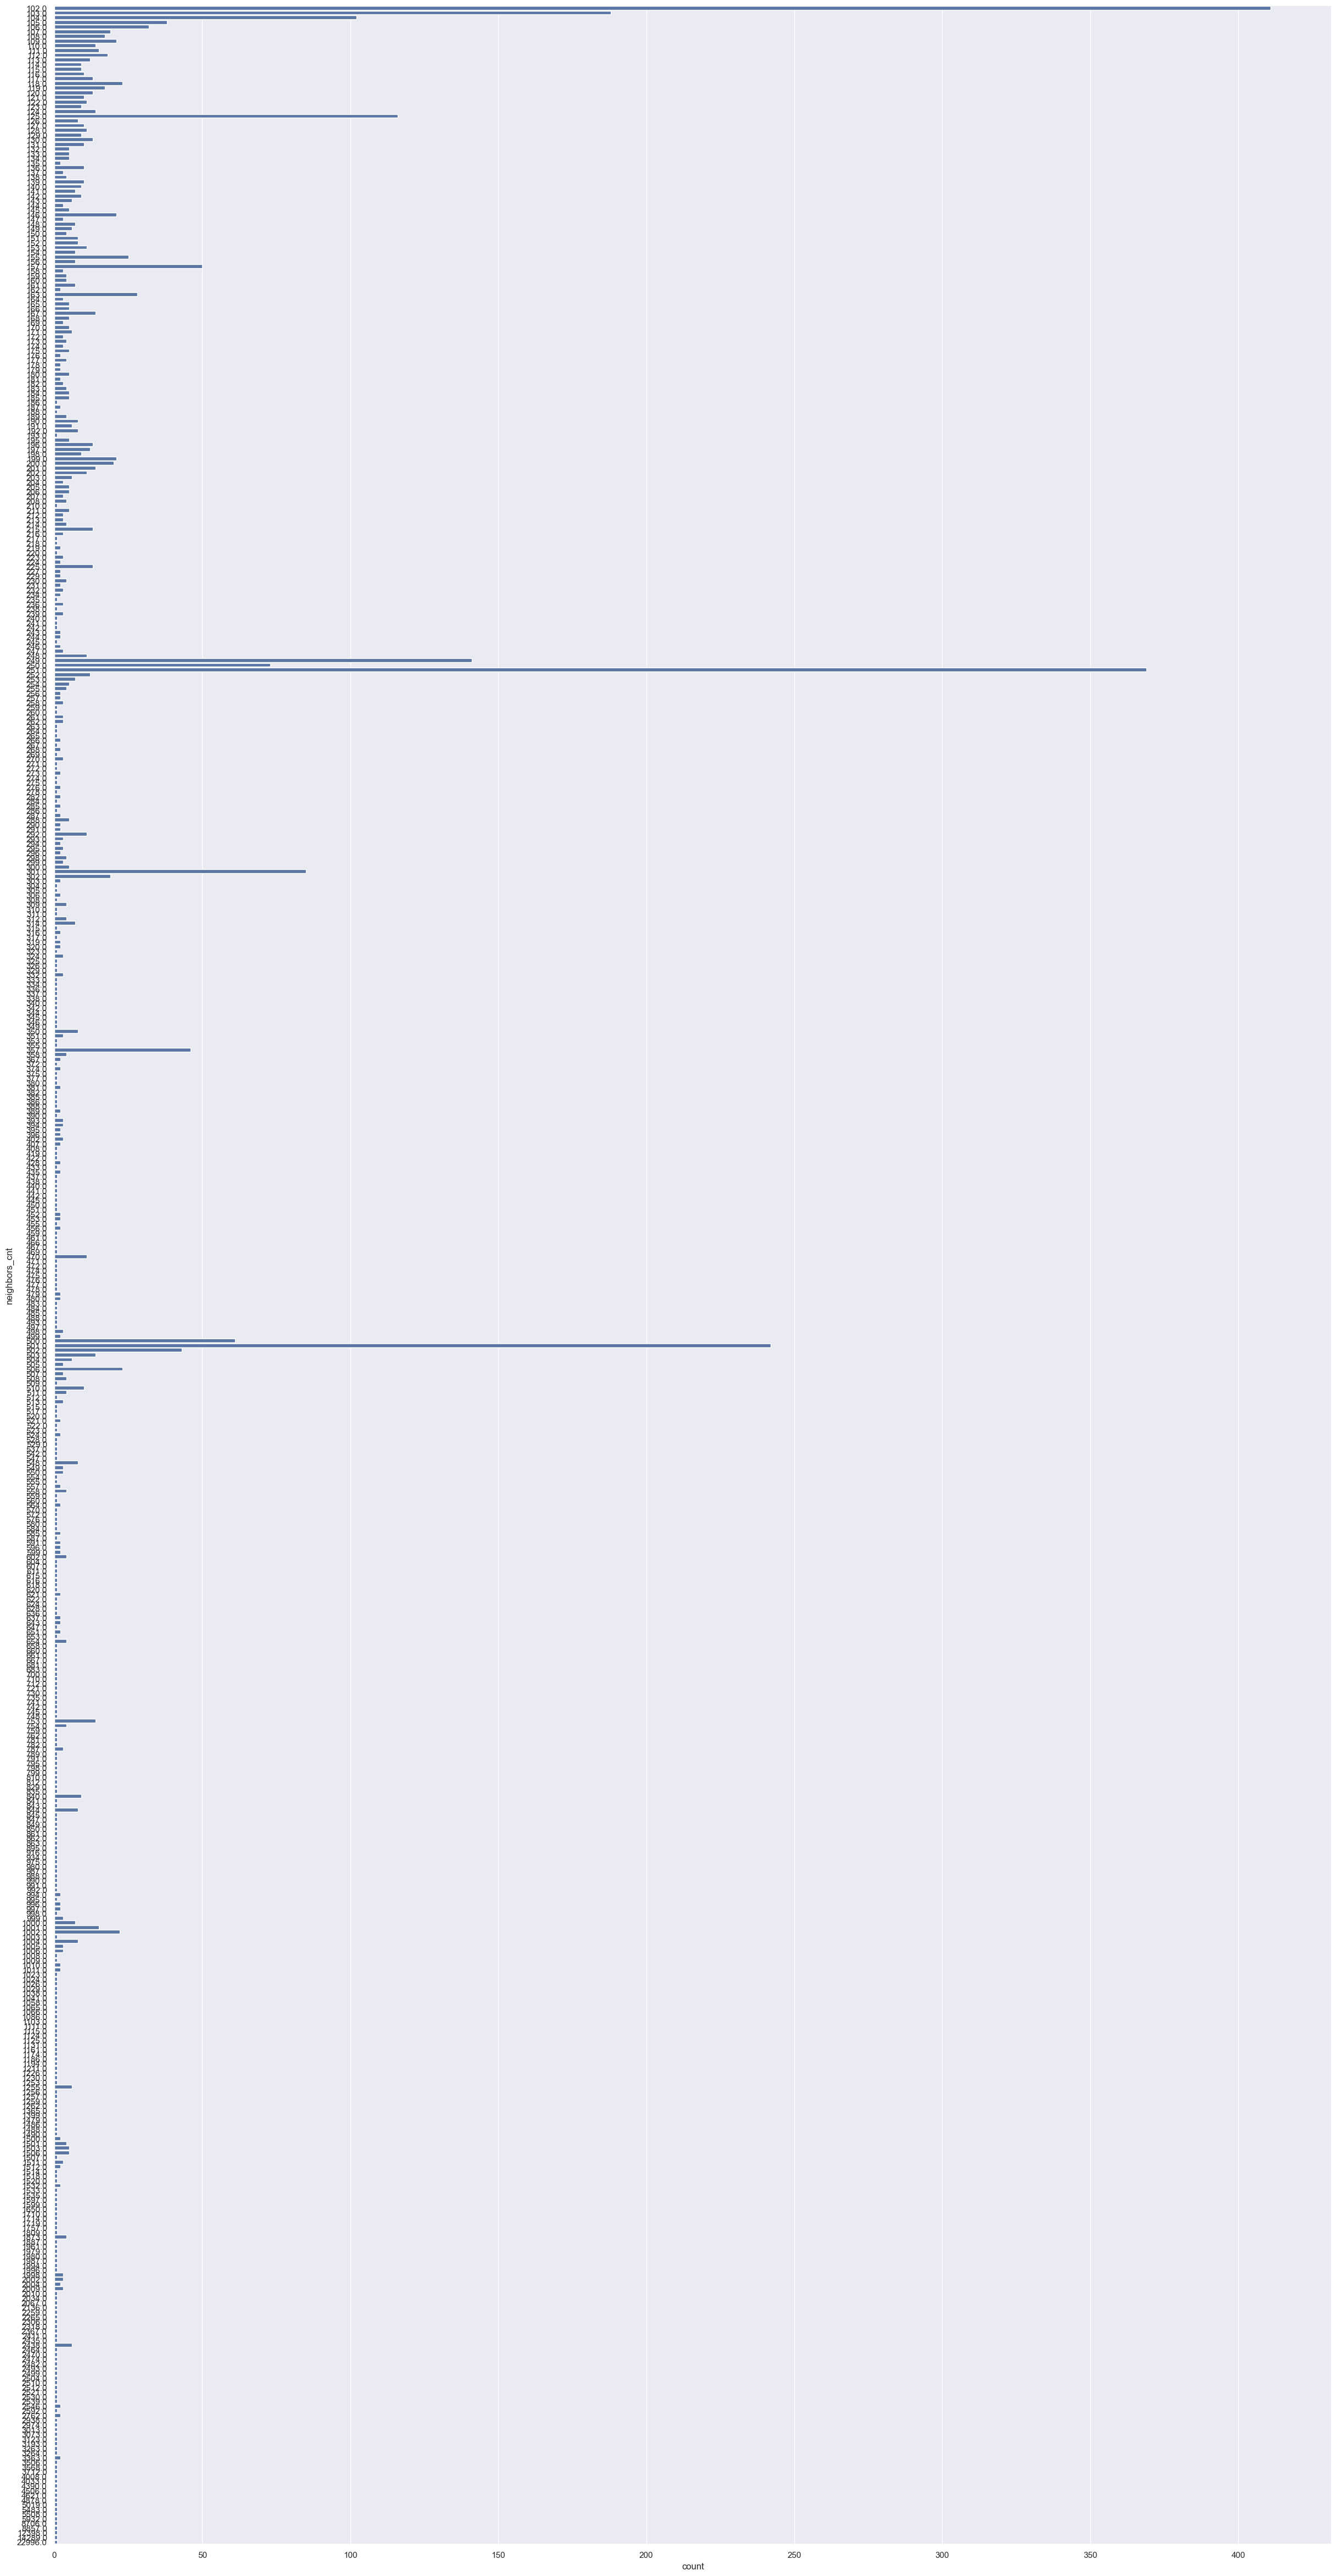

In [89]:
normal_actors = actor_to_neighbour_cnt[actor_to_neighbour_cnt["neighbors_cnt"] <= quantile_995]

suspicious_actors = actor_to_neighbour_cnt[actor_to_neighbour_cnt["neighbors_cnt"] > quantile_995]

plt.figure(figsize=(30, 60))

sns.countplot(data=suspicious_actors.sort_values(by='neighbors_cnt'), y='neighbors_cnt')


Есть большие выбросы на числе соседей, равном 500-502 и 249-251, очень много пользователей у которых столько соседей, надо будет их поисследовать детальнее

## Исследование числа транзакций на пользователя

In [90]:
addr_to_tx_df = pd.read_csv("./dataset/Elliptic++ Dataset/AddrTx_edgelist.csv")
tx_to_addr_df = pd.read_csv("./dataset/Elliptic++ Dataset/TxAddr_edgelist.csv")

In [91]:
actor_to_tx_cnt = addr_to_tx_df \
    .groupby("input_address") \
    .agg({
        "txId": "nunique",
    }) \
    .reset_index() \
    .rename(columns={
        "input_address": "actor_id",
        "txId": "outcoming_tx_cnt",
    })

actor_to_incoming_tx_cnt = tx_to_addr_df \
    .groupby("output_address") \
    .agg({
        "txId": "nunique",
    }) \
    .reset_index() \
    .rename(columns={
        "output_address": "actor_id",
        "txId": "incoming_tx_cnt",
    })

actor_to_incoming_tx_cnt.head()


,actor_id,incoming_tx_cnt
0,111112TykSw72ztDN2WJger4cynzWYC5w,1
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,8
2,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,1
3,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,1
4,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,1


In [92]:
actor_to_nei_and_tx_cnt = pd.merge(
    pd.merge(
        actor_to_neighbour_cnt,
        actor_to_tx_cnt,
        on="actor_id",
        how="left"
    ),
    actor_to_incoming_tx_cnt,
    on="actor_id",
    how="left"
)
actor_to_nei_and_tx_cnt["incoming_tx_cnt"] = actor_to_nei_and_tx_cnt["incoming_tx_cnt"].fillna(0)
actor_to_nei_and_tx_cnt["outcoming_tx_cnt"] = actor_to_nei_and_tx_cnt["outcoming_tx_cnt"].fillna(0)
actor_to_nei_and_tx_cnt.head()

,actor_id,outcoming_neighbors_cnt,incoming_neighbors_cnt,neighbors_cnt,outcoming_tx_cnt,incoming_tx_cnt
0,111112TykSw72ztDN2WJger4cynzWYC5w,0.0,24.0,24.0,0.0,1.0
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,0.0,8.0,8.0,0.0,8.0
2,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,0.0,1.0,1.0,0.0,1.0
3,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,2.0,2.0,4.0,1.0,1.0
4,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,0.0,5.0,5.0,0.0,1.0


In [93]:
actor_to_nei_and_tx_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822942 entries, 0 to 822941
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   actor_id                 822942 non-null  object 
 1   outcoming_neighbors_cnt  822942 non-null  float64
 2   incoming_neighbors_cnt   822942 non-null  float64
 3   neighbors_cnt            822942 non-null  float64
 4   outcoming_tx_cnt         822942 non-null  float64
 5   incoming_tx_cnt          822942 non-null  float64
dtypes: float64(5), object(1)
memory usage: 37.7+ MB


Получился маппинг `actor_id <-> neighbors_cnt,outcoming_tx_cnt,incoming_tx_cnt`



/var/folders/hx/706gk8zd6l36yv49hjrzjrt00000gn/T/ipykernel_5147/876517445.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspicious_actors_mapping["incoming_minus_outcoming_tx_cnt"] = suspicious_actors_mapping["incoming_tx_cnt"] - suspicious_actors_mapping["outcoming_tx_cnt"]


<Axes: xlabel='outcoming_neighbors_cnt', ylabel='incoming_minus_outcoming_tx_cnt'>

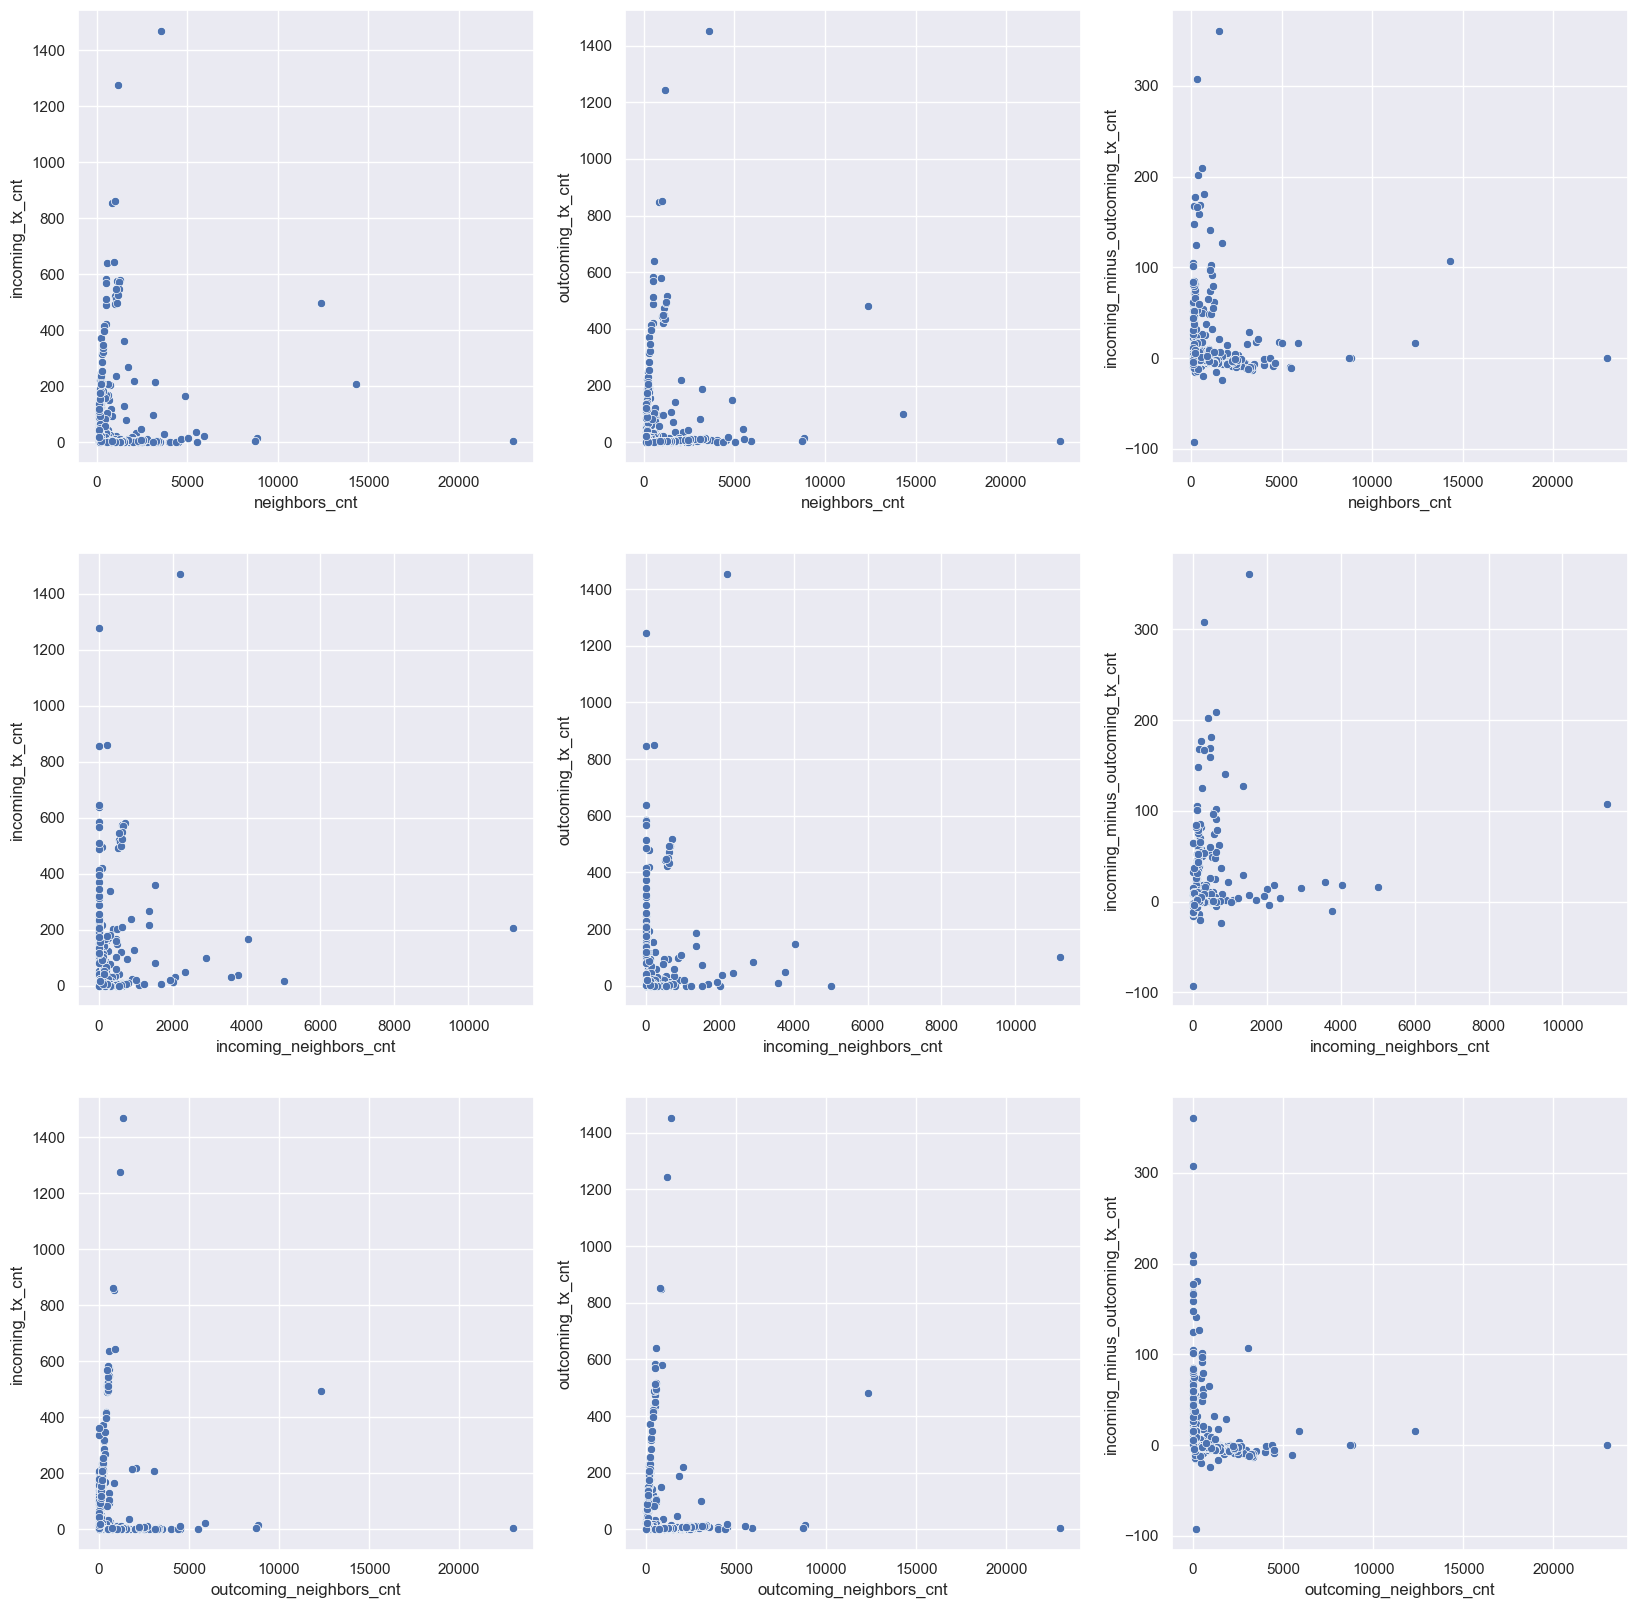

In [94]:
flg, ax = plt.subplots(3, 3, figsize=(20, 20))

suspicious_actors_mapping = actor_to_nei_and_tx_cnt[actor_to_nei_and_tx_cnt["neighbors_cnt"] > quantile_995]

suspicious_actors_mapping["incoming_minus_outcoming_tx_cnt"] = suspicious_actors_mapping["incoming_tx_cnt"] - suspicious_actors_mapping["outcoming_tx_cnt"]

sns.scatterplot(
    x="neighbors_cnt",
    y="incoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[0][0]
)
sns.scatterplot(
    x="neighbors_cnt",
    y="outcoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[0][1]
)
sns.scatterplot(
    x="neighbors_cnt",
    y="incoming_minus_outcoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[0][2]
)

sns.scatterplot(
    x="incoming_neighbors_cnt",
    y="incoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[1][0]
)
sns.scatterplot(
    x="incoming_neighbors_cnt",
    y="outcoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[1][1]
)
sns.scatterplot(
    x="incoming_neighbors_cnt",
    y="incoming_minus_outcoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[1][2]
)

sns.scatterplot(
    x="outcoming_neighbors_cnt",
    y="incoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[2][0]
)
sns.scatterplot(
    x="outcoming_neighbors_cnt",
    y="outcoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[2][1]
)
sns.scatterplot(
    x="outcoming_neighbors_cnt",
    y="incoming_minus_outcoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[2][2]
)


/var/folders/hx/706gk8zd6l36yv49hjrzjrt00000gn/T/ipykernel_5147/304988529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspicious_actors_mapping["incoming_minus_outcoming_tx_cnt"] = suspicious_actors_mapping["incoming_tx_cnt"] - suspicious_actors_mapping["outcoming_tx_cnt"]


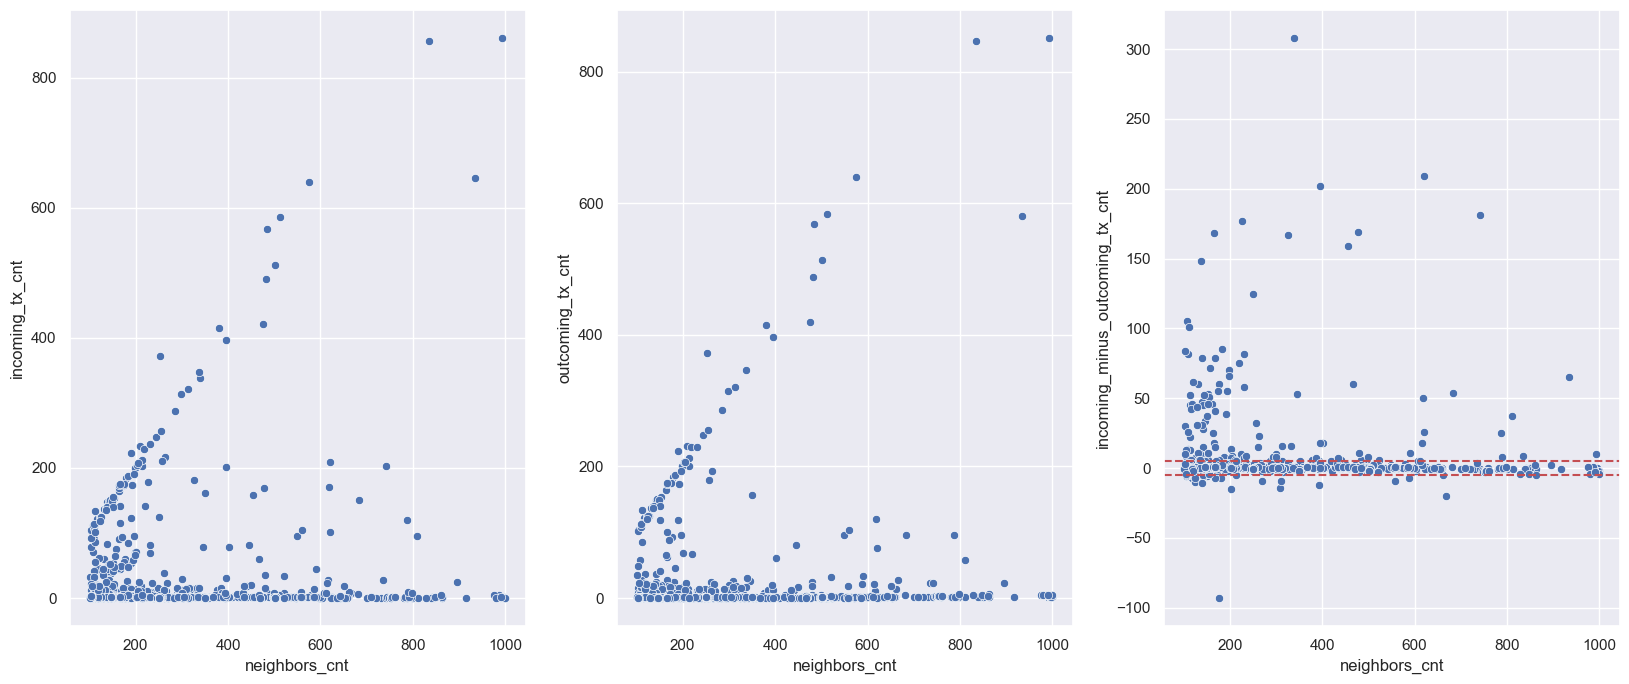

In [95]:
flg, ax = plt.subplots(1, 3, figsize=(20, 8))

suspicious_actors_mapping = actor_to_nei_and_tx_cnt[(actor_to_nei_and_tx_cnt["neighbors_cnt"] > quantile_995) & (actor_to_nei_and_tx_cnt["neighbors_cnt"] < 1000)]

suspicious_actors_mapping["incoming_minus_outcoming_tx_cnt"] = suspicious_actors_mapping["incoming_tx_cnt"] - suspicious_actors_mapping["outcoming_tx_cnt"]

sns.scatterplot(
    x="neighbors_cnt",
    y="incoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[0]
)
sns.scatterplot(
    x="neighbors_cnt",
    y="outcoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[1]
)
sns.scatterplot(
    x="neighbors_cnt",
    y="incoming_minus_outcoming_tx_cnt",
    data=suspicious_actors_mapping,
    ax=ax[2]
)

plt.axhline(y=5, color='r', linestyle='--')
plt.axhline(y=-5, color='r', linestyle='--')



Посмотрим детальнее на людей, у которых баланс incoming-outcoming маленький [-5 ; 5] 

<Axes: xlabel='neighbors_cnt', ylabel='outcoming_tx_cnt'>

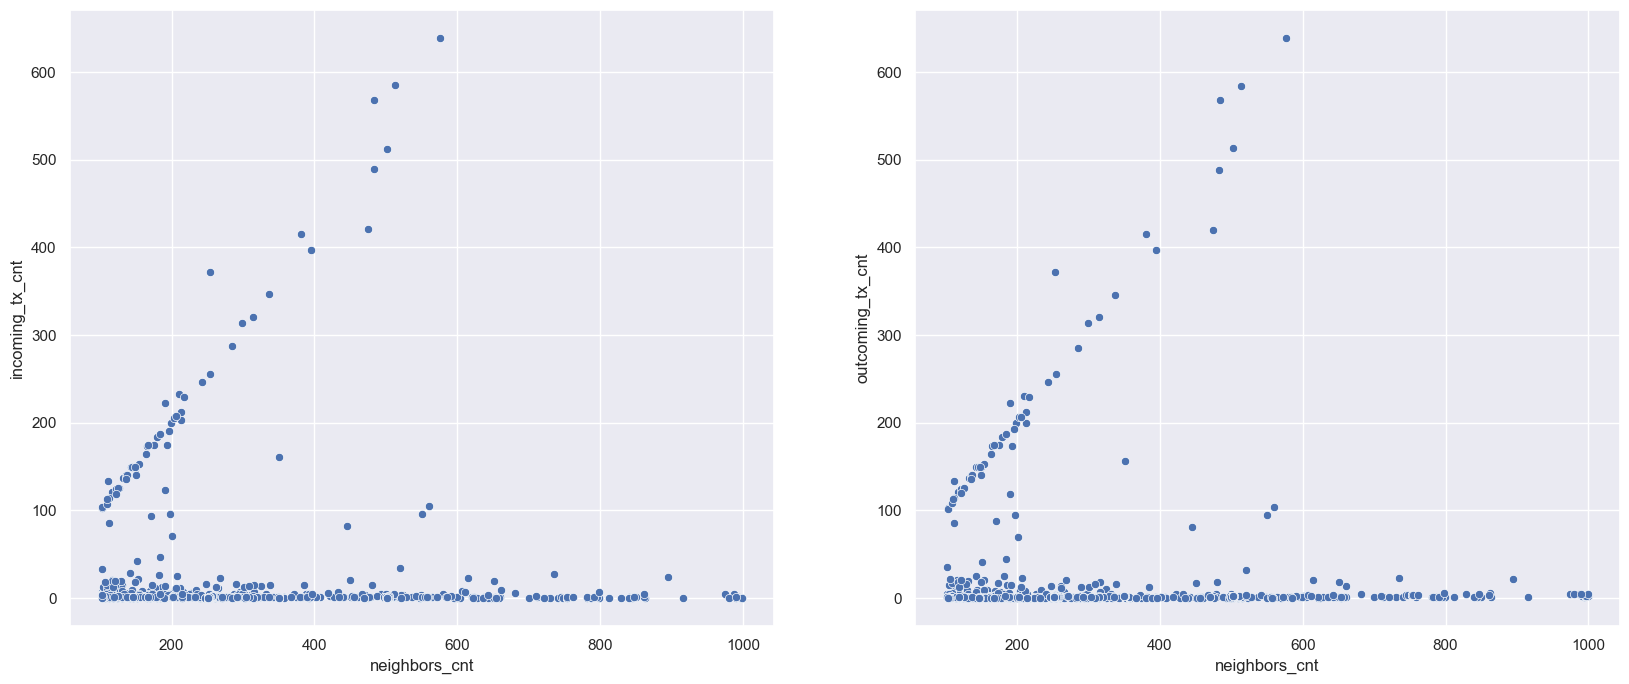

In [96]:
flg, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(
    x="neighbors_cnt",
    y="incoming_tx_cnt",
    data=suspicious_actors_mapping[suspicious_actors_mapping["incoming_minus_outcoming_tx_cnt"].abs() <= 5],
    ax=ax[0]
)
sns.scatterplot(
    x="neighbors_cnt",
    y="outcoming_tx_cnt",
    data=suspicious_actors_mapping[suspicious_actors_mapping["incoming_minus_outcoming_tx_cnt"].abs() <= 5],
    ax=ax[1]
)

Почему-то у большого числа таких людей (у которых много соседей) нулевые incoming и outcoming transactions number ??????

Но можем выделить из этих графиков челов, которые часто выступали посредниками между переводом средств - у них либо много поступающих и много уходящих транзакций

In [97]:
suspicious_actors_brokers = suspicious_actors_mapping[
    (suspicious_actors_mapping["incoming_minus_outcoming_tx_cnt"].abs() <= 5) # &
    # (suspicious_actors_mapping["incoming_tx_cnt"].abs() >= 100)
]
print(suspicious_actors_mapping.shape, suspicious_actors_brokers.shape) 
# suspicious_actors_brokers.shape

(3457, 7) (3321, 7)


Text(0.5, 1.0, 'Neighbors > 0.995 percentile, Incoming ~= outcoming txs')

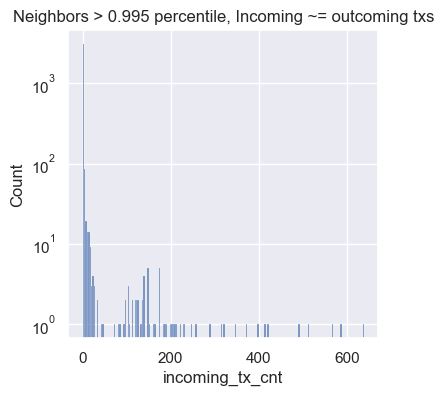

In [98]:
# Люди, у которых мало транзакций 
# suspicious_actors_brokers.sort_values(by="incoming_tx_cnt")

flg, ax = plt.subplots(figsize=(4, 4))

# sns.scatterplot(
#     x="incoming_tx_cnt",
#     y="outcoming_tx_cnt",
#     data=suspicious_actors_brokers,
# )
sns.histplot(
    data=suspicious_actors_brokers,
    x="incoming_tx_cnt",
    bins=200,
    # kde=True
)
ax.set_yscale("log")

ax.set_title("Neighbors > 0.995 percentile, Incoming ~= outcoming txs")


In [99]:
suspicious_actors_senders_receivers = suspicious_actors_mapping[
    (suspicious_actors_mapping["incoming_minus_outcoming_tx_cnt"].abs() > 5) # &
]


Text(0.5, 1.0, 'Neighbors > 0.995 percentile, Balanse > 5')

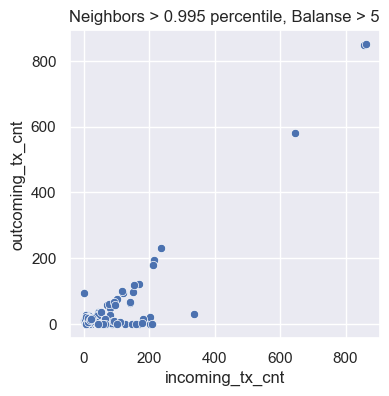

In [100]:
# Люди, у которых мало транзакций 
# suspicious_actors_brokers.sort_values(by="incoming_tx_cnt")

flg, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    x="incoming_tx_cnt",
    y="outcoming_tx_cnt",
    data=suspicious_actors_senders_receivers,
)
# ax.set_yscale("log")

ax.set_title("Neighbors > 0.995 percentile, Balanse > 5")


## Посмотрим, сколько среди них фродеров

In [101]:
wallets_classes = pd.read_csv("./dataset/Elliptic++ Dataset/wallets_classes.csv")
wallets_features = pd.read_csv("./dataset/Elliptic++ Dataset/wallets_features.csv")
wallets_features = wallets_features[["address", "btc_sent_total", "btc_sent_median", "btc_received_total", "btc_received_median"]] \
    .groupby(["address"]) \
    .agg({
        "btc_sent_total": "sum",
        "btc_sent_median": "mean",
        "btc_received_total": "sum",
        "btc_received_median": "mean",
    }) \
    .reset_index()

suspicious_actors_brokers_with_classes = pd.merge(
    suspicious_actors_brokers,
    wallets_classes,
    how="left",
    left_on="actor_id",
    right_on="address"
)
suspicious_actors_brokers_with_classes = pd.merge(
    suspicious_actors_brokers_with_classes,
    wallets_features,
    how="left",
    left_on="actor_id",
    right_on="address"
)

suspicious_actors_brokers_with_classes.head()

print(f"""
Brokers
Total: {suspicious_actors_brokers_with_classes.shape[0]}
Licit: {suspicious_actors_brokers_with_classes[suspicious_actors_brokers_with_classes["class"] == 2].shape[0]}
Illicit: {suspicious_actors_brokers_with_classes[suspicious_actors_brokers_with_classes["class"] == 1].shape[0]}
""")


Brokers
Total: 3321
Licit: 1766
Illicit: 23



In [102]:
suspicious_actors_brokers_with_classes.head()

,actor_id,outcoming_neighbors_cnt,incoming_neighbors_cnt,neighbors_cnt,outcoming_tx_cnt,incoming_tx_cnt,incoming_minus_outcoming_tx_cnt,address_x,class,address_y,btc_sent_total,btc_sent_median,btc_received_total,btc_received_median
0,1125nU5HY4Kwwg3cbb2eBGtMnw26n3ctTs,301.0,0.0,301.0,1.0,0.0,-1.0,1125nU5HY4Kwwg3cbb2eBGtMnw26n3ctTs,3,1125nU5HY4Kwwg3cbb2eBGtMnw26n3ctTs,0.001175,0.001175,0.0,0.00
1,113GSSzrDMyuNRnQsywFZu2s3SWgRpYQup,28.0,99.0,127.0,1.0,1.0,0.0,113GSSzrDMyuNRnQsywFZu2s3SWgRpYQup,2,113GSSzrDMyuNRnQsywFZu2s3SWgRpYQup,0.200000,0.050000,0.2,0.05
2,113GUoEqRKEoHWp6KNntbFJMGGECHaeLh9,501.0,0.0,501.0,1.0,0.0,-1.0,113GUoEqRKEoHWp6KNntbFJMGGECHaeLh9,2,113GUoEqRKEoHWp6KNntbFJMGGECHaeLh9,0.001100,0.001100,0.0,0.00
3,113Vw6u96sbkGAfaXxEbX6Q9crirNwgHNm,250.0,0.0,250.0,1.0,0.0,-1.0,113Vw6u96sbkGAfaXxEbX6Q9crirNwgHNm,2,113Vw6u96sbkGAfaXxEbX6Q9crirNwgHNm,0.010000,0.010000,0.0,0.00
4,113jKLsikYBPAXX3itEcoQboohYb2CGFoz,251.0,0.0,251.0,1.0,0.0,-1.0,113jKLsikYBPAXX3itEcoQboohYb2CGFoz,3,113jKLsikYBPAXX3itEcoQboohYb2CGFoz,0.500000,0.500000,0.0,0.00


In [103]:
# suspicious_actors_brokers_with_classes[suspicious_actors_brokers_with_classes["class"] == 1].to_excel("./brokers_illicit.xlsx")
suspicious_actors_brokers_with_classes[suspicious_actors_brokers_with_classes["class"] == 2].to_excel("./brokers_licit.xlsx")

Text(0.5, 1.0, 'Neighbors > 0.995 percentile, Incoming ~= outcoming txs')

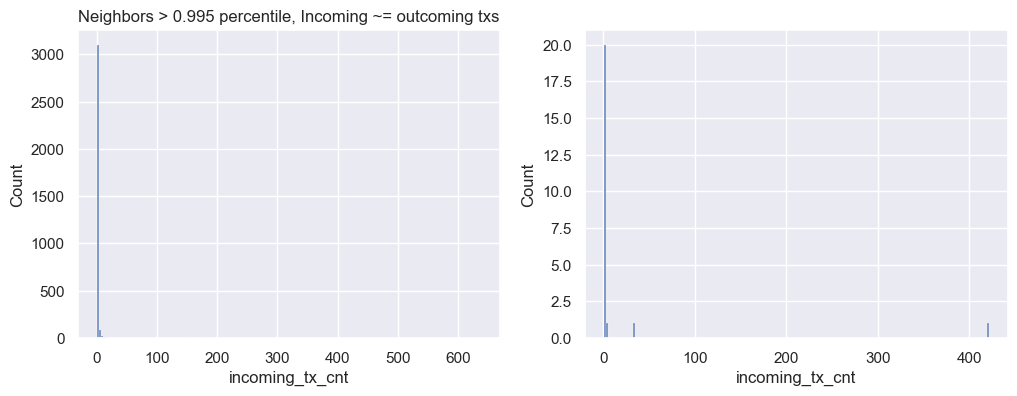

In [104]:
# Люди, у которых мало транзакций 
# suspicious_actors_brokers.sort_values(by="incoming_tx_cnt")

flg, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(
    data=suspicious_actors_brokers_with_classes,
    x="incoming_tx_cnt",
    bins=200,
    ax=ax[0]
    # kde=True
)
sns.histplot(
    data=suspicious_actors_brokers_with_classes[suspicious_actors_brokers_with_classes["class"] == 1],
    x="incoming_tx_cnt",
    bins=200,
    ax=ax[1]
    # kde=True
)
# ax.set_yscale("log")

ax[0].set_title("Neighbors > 0.995 percentile, Incoming ~= outcoming txs")


In [105]:
wallets_classes = pd.read_csv("./dataset/Elliptic++ Dataset/wallets_classes.csv")
wallets_features = pd.read_csv("./dataset/Elliptic++ Dataset/wallets_features.csv")
wallets_features = wallets_features[["address", "btc_sent_total", "btc_sent_median", "btc_received_total", "btc_received_median"]] \
    .groupby(["address"]) \
    .agg({
        "btc_sent_total": "sum",
        "btc_sent_median": "mean",
        "btc_received_total": "sum",
        "btc_received_median": "mean",
    }) \
    .reset_index()

suspicious_actors_senders_receivers_with_classes = pd.merge(
    suspicious_actors_senders_receivers,
    wallets_classes,
    how="left",
    left_on="actor_id",
    right_on="address"
)
suspicious_actors_senders_receivers_with_classes = pd.merge(
    suspicious_actors_senders_receivers_with_classes,
    wallets_features,
    how="left",
    left_on="actor_id",
    right_on="address"
)
suspicious_actors_senders_receivers_with_classes.head()

print(f"""
Brokers
Total: {suspicious_actors_senders_receivers_with_classes.shape[0]}
Licit: {suspicious_actors_senders_receivers_with_classes[suspicious_actors_senders_receivers_with_classes["class"] == 2].shape[0]}
Illicit: {suspicious_actors_senders_receivers_with_classes[suspicious_actors_senders_receivers_with_classes["class"] == 1].shape[0]}
""")


Brokers
Total: 136
Licit: 48
Illicit: 1



In [106]:
suspicious_actors_senders_receivers_with_classes.to_excel("./senders_receivers_licit.xlsx")


Много соседей, примерно одинаковое число транзакций - 
* В основном всего транзакций очень мало
* Есть те, у которых много вход/выход транзкаций  (единицы)


Посмотрим теперб на человека, у которого много соседей и высокая разница между incoming/outcoming транзакций

# Ищем компоненты связности

In [107]:
wallets_classes = pd.read_csv("./dataset/Elliptic++ Dataset/wallets_classes.csv")

# cutoff = "14bHMgHDJGxDh8E65WS5FxPDUWTz6D738H"
# cutoff = "19ec7G3pPb3qdEmvybVZQgr8JA5WbUvVuH"
cutoff = "ZZZZ"
wallets_classes = wallets_classes[wallets_classes["address"] <= cutoff]
wallets_classes.shape
addr_to_addr_df_prep = addr_to_addr_df[
    addr_to_addr_df["input_address"].isin(wallets_classes["address"]) &
    addr_to_addr_df["output_address"].isin(wallets_classes["address"])
]
nodes = list(wallets_classes["address"])
len(nodes)

# nodes = list(wallets_classes[
#     wallets_classes["address"].isin(addr_to_addr_df["input_address"]) | wallets_classes["address"].isin(addr_to_addr_df["output_address"])
# ]["address"])


822942

In [108]:
wallets_classes[wallets_classes["class"] == 3].shape

(557588, 2)

In [109]:
from collections import defaultdict

edges = defaultdict(lambda : [])
edges_t = defaultdict(lambda : [])


for index, edge in addr_to_addr_df_prep.iterrows():
    edges[edge["input_address"]].append(edge["output_address"])
    edges_t[edge["output_address"]].append(edge["input_address"])
    


In [110]:
visited = defaultdict(lambda : False)
component = defaultdict(lambda : -1)
cnt_components = 0
order = []

def dfs1(current_node):
    visited[current_node] = True
    for nei in edges[current_node]:
        if visited[nei]:
            continue
        dfs1(nei)
    order.append(current_node)

def dfs2(current_node):
    component[current_node] = cnt_components
    for nei in edges_t[current_node]:
        if component[nei] == -1:
            dfs2(nei)

for node in nodes:
    if not visited[node]:
        dfs1(node)

for node in reversed(order):
    if component[node] == -1:
        dfs2(node)
        cnt_components += 1

print(cnt_components)

804562


In [111]:
component_dataframe_dict = {
    "actor_id": [],
    "component": [],
}
for node, comp in component.items():
    component_dataframe_dict["actor_id"].append(node)
    component_dataframe_dict["component"].append(comp)

components_df = pd.DataFrame(component_dataframe_dict)

components_df.shape

(822942, 2)

In [112]:
component_to_actors_cnt = components_df \
    .groupby("component") \
    .agg({
        "actor_id": "nunique",
    }) \
    .reset_index() \
    .rename(columns={
        "actor_id": "actors_cnt",
    })

component_to_actors_cnt[component_to_actors_cnt["actors_cnt"] > 1].shape

(79, 2)

In [113]:
component_to_actors_cnt[component_to_actors_cnt["actors_cnt"] > 1].reset_index().sort_values(by="actors_cnt", ascending=False)

,index,component,actors_cnt
53,693620,693620,17773
66,768443,768443,133
55,710953,710953,68
75,800318,800318,60
72,795735,795735,46
...,...,...,...
12,277598,277598,2
51,689220,689220,2
11,276508,276508,2
10,276226,276226,2


In [114]:
component_to_actors_cnt[component_to_actors_cnt["actors_cnt"] == 2].shape

(38, 2)

Обратимся к данным по фродерским кошелькам

In [115]:
wallets_classes_renamed = wallets_classes.copy()
wallets_classes_renamed["actor_id"] = wallets_classes_renamed["address"]
wallets_classes_renamed = wallets_classes_renamed.drop("address", axis=1)
wallets_classes_renamed

actors_with_components_and_classes = pd.merge(
    components_df,
    wallets_classes_renamed,
    on="actor_id",
    how="left"
)

actors_with_components_and_classes = pd.merge(
    actors_with_components_and_classes,
    component_to_actors_cnt,
    on="component",
    how="left"
) \
    .rename(columns={
        "actors_cnt": "component_actors_cnt",
    })

actors_with_components_and_classes


,actor_id,component,class,component_actors_cnt
0,3R2bm6iqbzcVpEeFCSFarS56b56QfjyiSW,0,3,1
1,3R2PkovCpT6ZkV6ubHUR5u8sQJqmKKKAxA,1,3,1
2,3R2JPovtuUHnKD3nwErqxch9JdTATBNKkB,2,3,1
3,3R2Ewq861Z37owvMkGkor2RqQxYNthkAJq,3,3,1
4,3R2CnSAXkht8NFG1BaqaADvKo4N66ngovq,4,2,1
...,...,...,...,...
822937,15NDGdu6j7h2vtfNH3bnjGbr3Ztkho6gKa,804557,3,1
822938,1KWbPoFkzadegdff9rCK1wBFu3mD8M17Wp,804558,3,1
822939,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,804559,2,1
822940,1111DAYXhoxZx2tsRnzimfozo783x1yC2,804560,3,1


In [116]:
def count_illicit(group):
    return pd.Series({
        "illit_actors_cnt": (group['class'] == 1).sum(),
        "all_actors_cnt": group["component_actors_cnt"].iloc[0]
    })

component_to_illicit_actors_cnt = actors_with_components_and_classes \
    .groupby("component") \
    .apply(count_illicit)

/var/folders/hx/706gk8zd6l36yv49hjrzjrt00000gn/T/ipykernel_5147/203838519.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  component_to_illicit_actors_cnt = actors_with_components_and_classes \


In [117]:
component_to_illicit_actors_cnt[
    (component_to_illicit_actors_cnt["illit_actors_cnt"] > 0)
].sort_values(by="all_actors_cnt", ascending=False)
# actors_with_components_and_classes[actors_with_components_and_classes["class"] == 1].shape

,illit_actors_cnt,all_actors_cnt
component,,
693620,35,17773
736429,4,6
411790,1,4
55168,1,1
447706,1,1
...,...,...
232454,1,1
232504,1,1
232525,1,1


Text(0.5, 1.0, 'Licit to incoming tx')

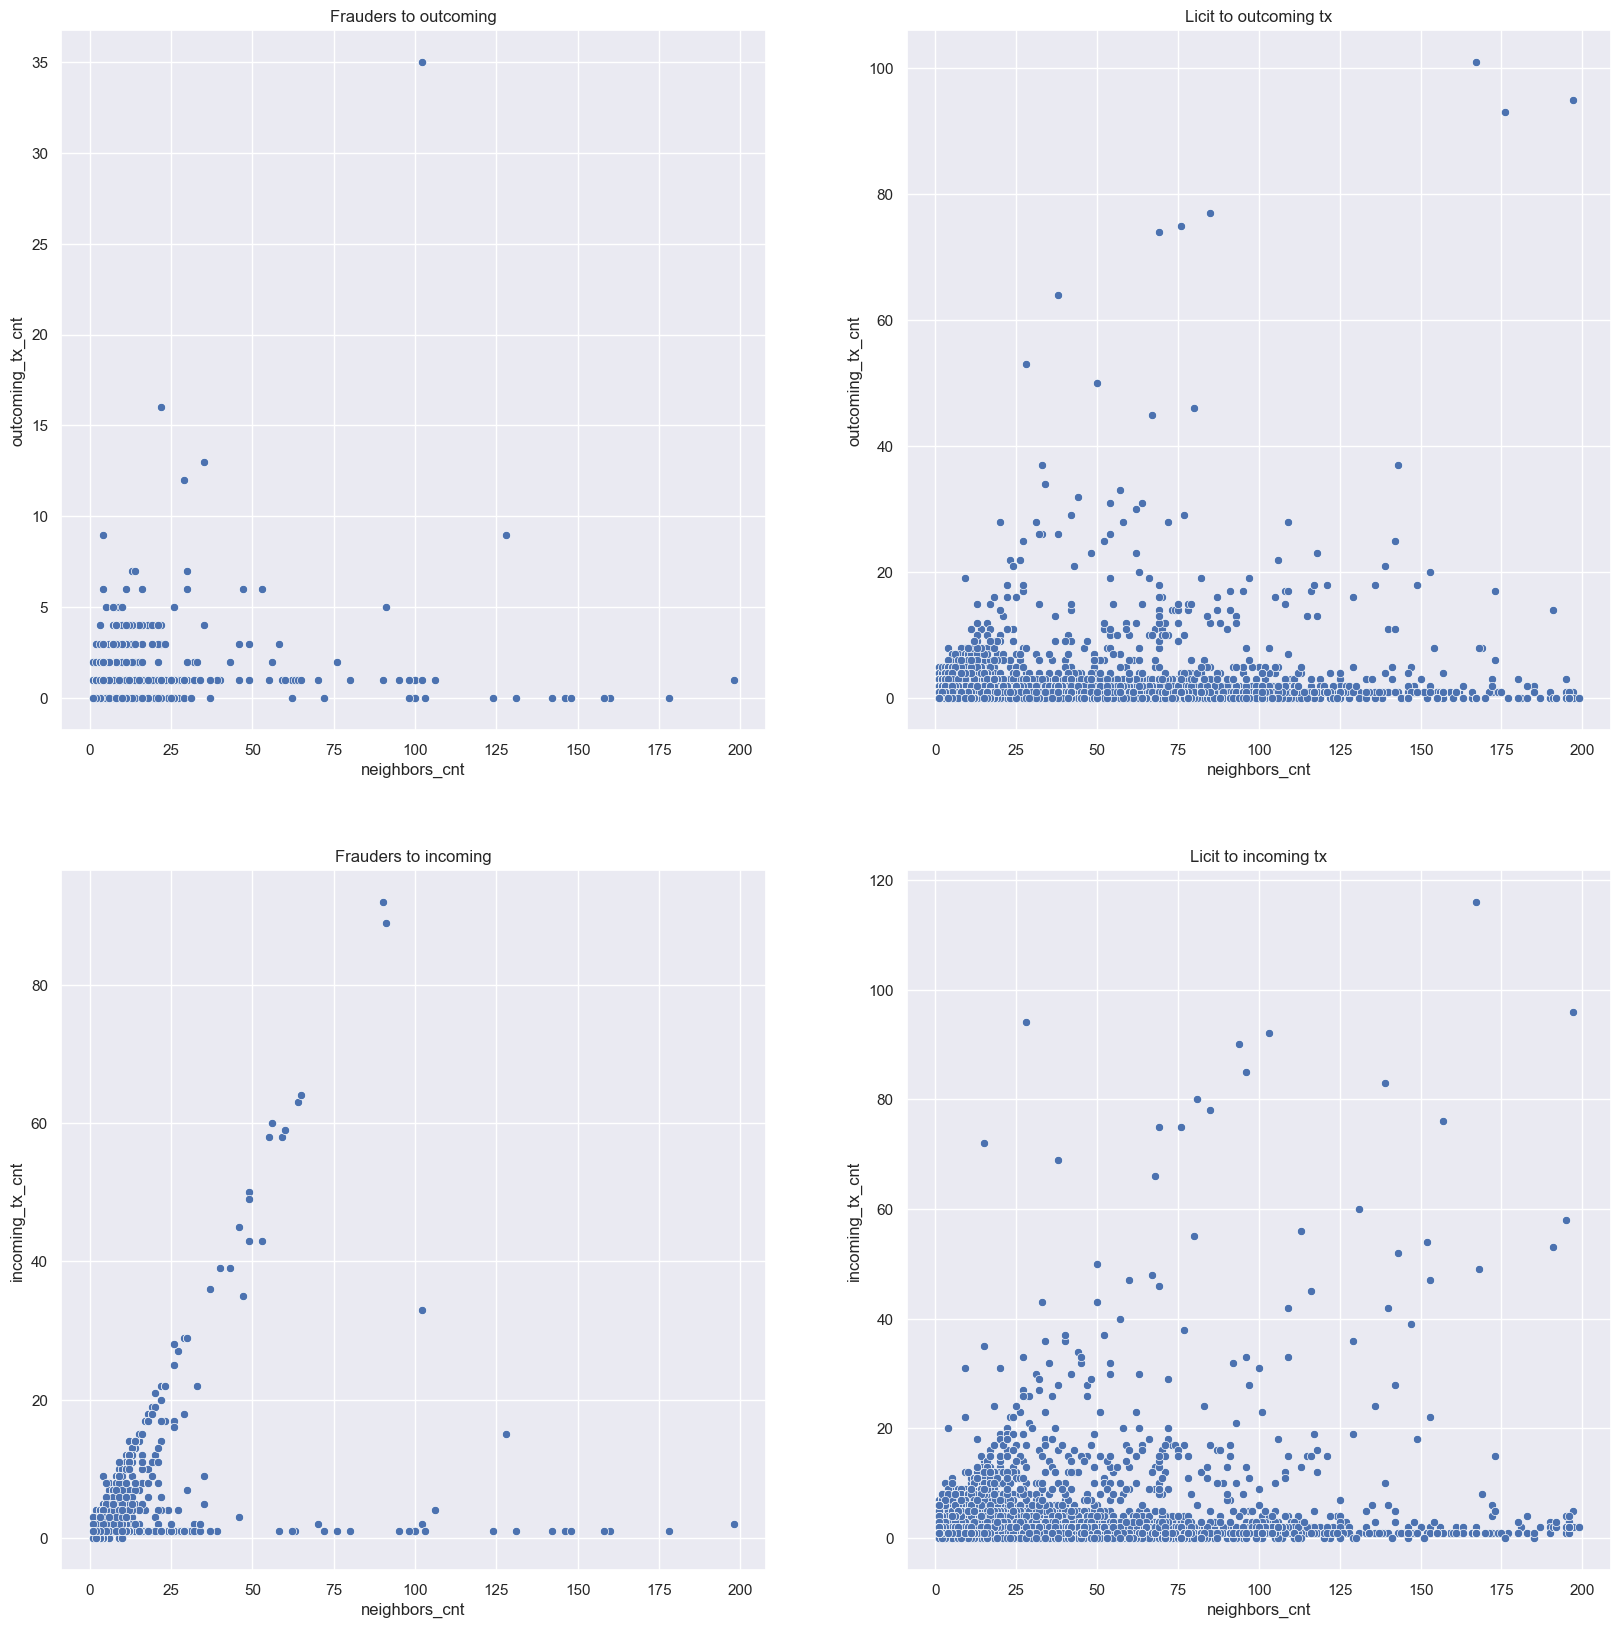

In [128]:

actor_to_nei_and_tx_cnt_with_status = pd.merge(
    actor_to_nei_and_tx_cnt,
    wallets_classes_renamed,
    on="actor_id",
    how="left",
)
actor_to_nei_and_tx_cnt_with_status.head()

flg, ax = plt.subplots(2, 2, figsize=(20, 20))

sns.scatterplot(
    x="neighbors_cnt",
    y="outcoming_tx_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 1) &
        (actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] < 200)
    ],
    ax=ax[0][0]
)
ax[0][0].set_title("Frauders to outcoming")
sns.scatterplot(
    x="neighbors_cnt",
    y="outcoming_tx_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 2) &
        ((actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] < 200))
    ],
    ax=ax[0][1]
)
ax[0][1].set_title("Licit to outcoming tx")

sns.scatterplot(
    x="neighbors_cnt",
    y="incoming_tx_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 1) &
        (actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] < 200)
    ],
    ax=ax[1][0]
)
ax[1][0].set_title("Frauders to incoming")
sns.scatterplot(
    x="neighbors_cnt",
    y="incoming_tx_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 2) &
        ((actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] < 200))
    ],
    ax=ax[1][1]
)
ax[1][1].set_title("Licit to incoming tx")


Text(0.5, 1.0, 'Licit to incoming tx')

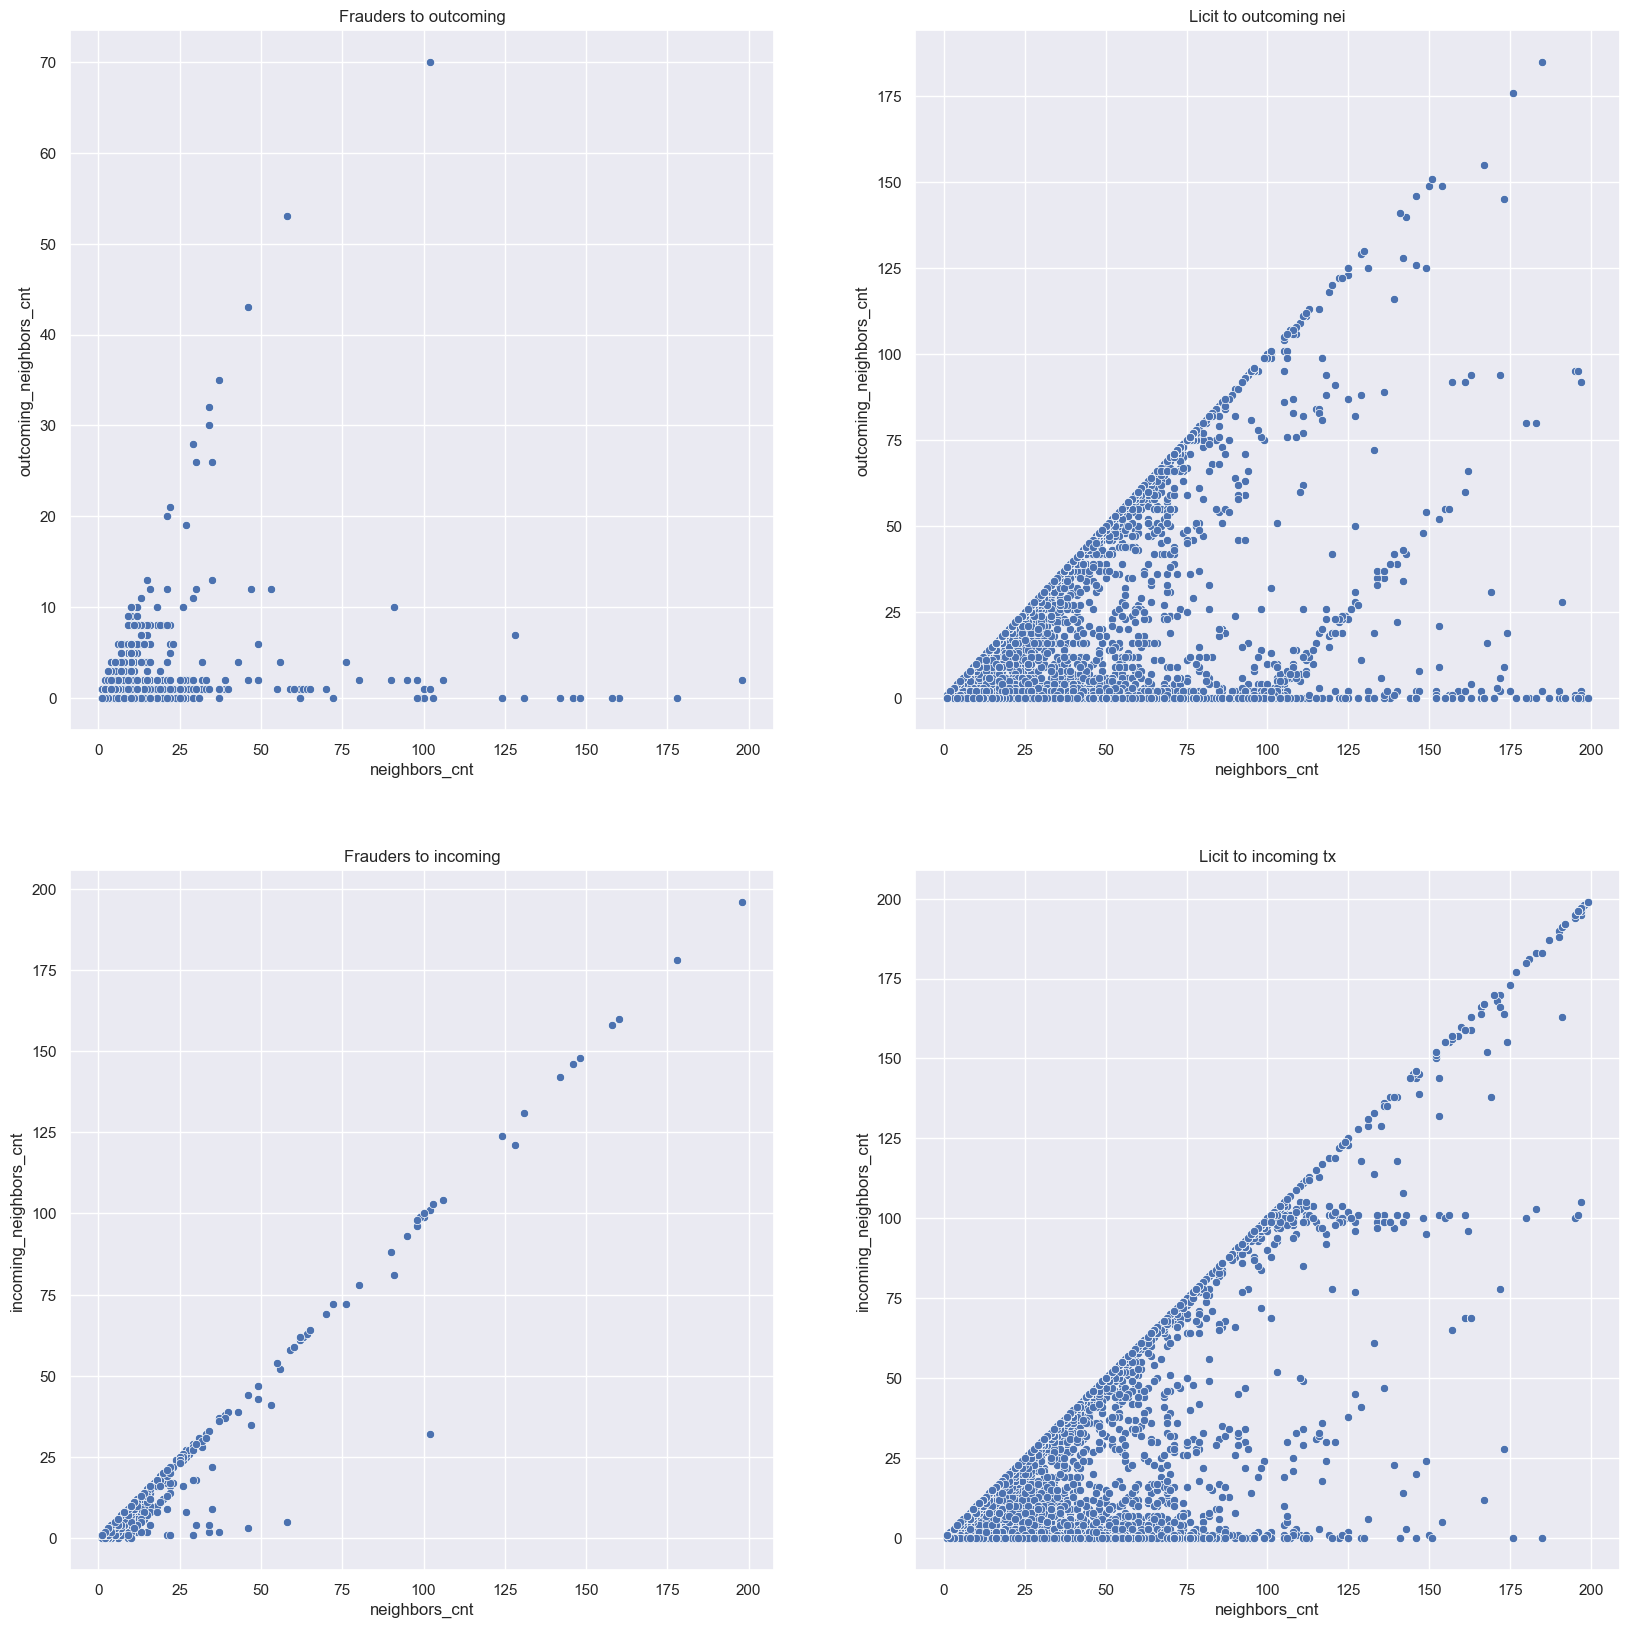

In [129]:

actor_to_nei_and_tx_cnt_with_status = pd.merge(
    actor_to_nei_and_tx_cnt,
    wallets_classes_renamed,
    on="actor_id",
    how="left",
)
actor_to_nei_and_tx_cnt_with_status.head()

flg, ax = plt.subplots(2, 2, figsize=(20, 20))

sns.scatterplot(
    x="neighbors_cnt",
    y="outcoming_neighbors_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 1) &
        (actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] < 200)
    ],
    ax=ax[0][0]
)
ax[0][0].set_title("Frauders to outcoming")
sns.scatterplot(
    x="neighbors_cnt",
    y="outcoming_neighbors_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 2) &
        ((actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] < 200))
    ],
    ax=ax[0][1]
)
ax[0][1].set_title("Licit to outcoming nei")

sns.scatterplot(
    x="neighbors_cnt",
    y="incoming_neighbors_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 1) &
        (actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] < 200)
    ],
    ax=ax[1][0]
)
ax[1][0].set_title("Frauders to incoming")
sns.scatterplot(
    x="neighbors_cnt",
    y="incoming_neighbors_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 2) &
        ((actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] < 200))
    ],
    ax=ax[1][1]
)
ax[1][1].set_title("Licit to incoming tx")


<Axes: xlabel='neighbors_cnt', ylabel='outcoming_tx_cnt'>

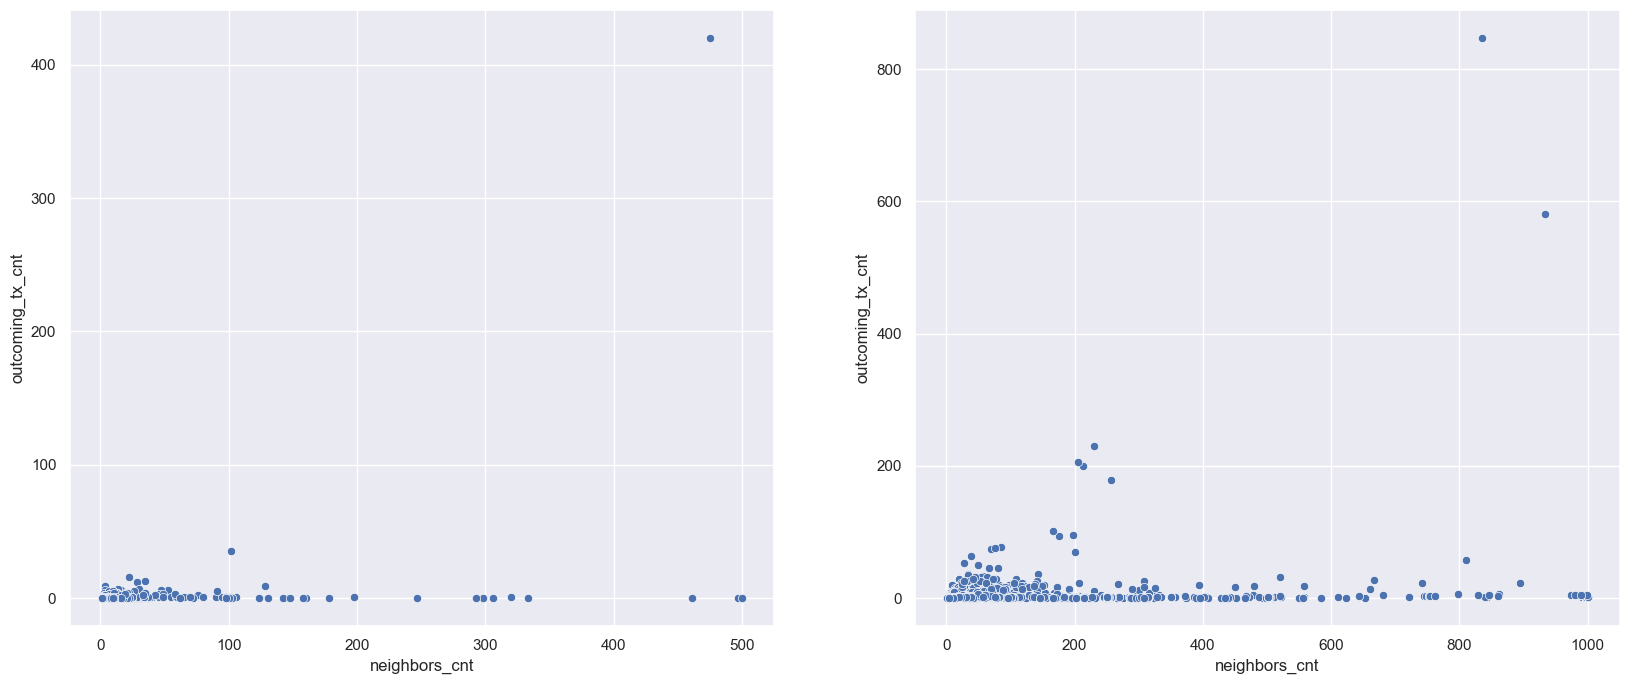

In [119]:
actor_to_nei_and_tx_cnt_with_status = pd.merge(
    actor_to_nei_and_tx_cnt,
    wallets_classes_renamed,
    on="actor_id",
    how="left",
)
actor_to_nei_and_tx_cnt_with_status.head()

flg, ax = plt.subplots(1, 2, figsize=(20, 8))

# suspicious_actors_mapping = actor_to_nei_and_tx_cnt[(actor_to_nei_and_tx_cnt["neighbors_cnt"] > quantile_995) & (actor_to_nei_and_tx_cnt["neighbors_cnt"] < 1000)]

# suspicious_actors_mapping["incoming_minus_outcoming_tx_cnt"] = suspicious_actors_mapping["incoming_tx_cnt"] - suspicious_actors_mapping["outcoming_tx_cnt"]

# sns.scatterplot(
#     x="neighbors_cnt",
#     y="incoming_tx_cnt",
#     data=actor_to_nei_and_tx_cnt_with_status[actor_to_nei_and_tx_cnt_with_status["class"] == 1],
#     ax=ax[0],
# )
# sns.scatterplot(
#     x="neighbors_cnt",
#     y="incoming_tx_cnt",
#     data=actor_to_nei_and_tx_cnt_with_status[actor_to_nei_and_tx_cnt_with_status["class"] != 1],
#     ax=ax[1]
# )
sns.scatterplot(
    x="neighbors_cnt",
    y="outcoming_tx_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 1) & (actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] <= 1000)
    ],
    ax=ax[0]
)
sns.scatterplot(
    x="neighbors_cnt",
    y="outcoming_tx_cnt",
    data=actor_to_nei_and_tx_cnt_with_status[(actor_to_nei_and_tx_cnt_with_status["class"] == 2) & (actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] <= 1000)],
    ax=ax[1]
)
# sns.scatterplot(
#     x="neighbors_cnt",
#     y="outcoming_tx_cnt",
#     data=suspicious_actors_mapping,
#     ax=ax[1]
# )
# sns.scatterplot(
#     x="neighbors_cnt",
#     y="incoming_minus_outcoming_tx_cnt",
#     data=suspicious_actors_mapping,
#     ax=ax[2]
# )

# plt.axhline(y=5, color='r', linestyle='--')
# plt.axhline(y=-5, color='r', linestyle='--')

In [120]:
actor_to_nei_and_tx_cnt_with_status[
        (actor_to_nei_and_tx_cnt_with_status["class"] == 1) & (actor_to_nei_and_tx_cnt_with_status["neighbors_cnt"] <= 1000)
    ].shape

(14265, 7)

### Смотрим на КСС из 6 актеров с 4 фродерами

In [134]:
illicit_component_id = 736429
illicit_comp_actors = components_df[components_df["component"] == illicit_component_id]["actor_id"].reset_index()
illicit_comp_actors

,index,actor_id
0,754486,3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf
1,754487,15d3hPxB2PQQQgNCdtyzh2TWZBKWpELBwX
2,754488,1LC8iYEvXfx95wTmeVwDwCbSP1jpJtmmJa
3,754489,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku
4,754490,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw
5,754491,1E23HLJYhLzxDu63hWtgSfJEkzHNRyFvRp


In [139]:
wallets_features = pd.read_csv("./dataset/Elliptic++ Dataset/wallets_features_classes_combined.csv")

wallets_features = wallets_features[["address", "class", "btc_sent_total", "btc_sent_median", "btc_received_total", "btc_received_median"]] \
    .groupby(["address", "class"]) \
    .agg({
        "btc_sent_total": "sum",
        "btc_sent_median": "mean",
        "btc_received_total": "sum",
        "btc_received_median": "mean",
    }) \
    .reset_index()

illicit_comp_actors = pd.merge(
    illicit_comp_actors,
    wallets_features,
    how="left",
    left_on="actor_id",
    right_on="address"
)
illicit_comp_actors.sort_values("actor_id")


,index,actor_id,address_x,class_x,btc_sent_total_x,btc_sent_median_x,btc_received_total_x,btc_received_median_x,address_y,class_y,btc_sent_total_y,btc_sent_median_y,btc_received_total_y,btc_received_median_y,address,class,btc_sent_total,btc_sent_median,btc_received_total,btc_received_median
1,754487,15d3hPxB2PQQQgNCdtyzh2TWZBKWpELBwX,15d3hPxB2PQQQgNCdtyzh2TWZBKWpELBwX,3,0.025494,0.006374,0.025494,0.006374,15d3hPxB2PQQQgNCdtyzh2TWZBKWpELBwX,3,0.025494,0.006374,0.025494,0.006374,15d3hPxB2PQQQgNCdtyzh2TWZBKWpELBwX,3,0.025494,0.006374,0.025494,0.006374
5,754491,1E23HLJYhLzxDu63hWtgSfJEkzHNRyFvRp,1E23HLJYhLzxDu63hWtgSfJEkzHNRyFvRp,3,0.023006,0.005752,0.023006,0.005752,1E23HLJYhLzxDu63hWtgSfJEkzHNRyFvRp,3,0.023006,0.005752,0.023006,0.005752,1E23HLJYhLzxDu63hWtgSfJEkzHNRyFvRp,3,0.023006,0.005752,0.023006,0.005752
3,754489,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,1,2.971878,0.001166,0.824820,0.000000,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,1,2.971878,0.001166,0.824820,0.000000,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,1,2.971878,0.001166,0.824820,0.000000
2,754488,1LC8iYEvXfx95wTmeVwDwCbSP1jpJtmmJa,1LC8iYEvXfx95wTmeVwDwCbSP1jpJtmmJa,1,0.020362,0.005091,0.020362,0.005091,1LC8iYEvXfx95wTmeVwDwCbSP1jpJtmmJa,1,0.020362,0.005091,0.020362,0.005091,1LC8iYEvXfx95wTmeVwDwCbSP1jpJtmmJa,1,0.020362,0.005091,0.020362,0.005091
0,754486,3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf,3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf,1,0.327886,0.000000,1.198226,0.001357,3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf,1,0.327886,0.000000,1.198226,0.001357,3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf,1,0.327886,0.000000,1.198226,0.001357
4,754490,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw,1,0.066009,0.000000,1.027897,0.001351,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw,1,0.066009,0.000000,1.027897,0.001351,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw,1,0.066009,0.000000,1.027897,0.001351


In [142]:
addr_to_tx = pd.read_csv("./dataset/Elliptic++ Dataset/AddrTx_edgelist.csv")
addr_to_tx[addr_to_tx["input_address"].isin(illicit_comp_actors["actor_id"])].sort_values("txId")

,input_address,txId
340461,3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf,29591601
258343,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,85002291
258902,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,85002368
269955,15d3hPxB2PQQQgNCdtyzh2TWZBKWpELBwX,104777595
266614,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,163586982
269519,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,163691027
267293,1LC8iYEvXfx95wTmeVwDwCbSP1jpJtmmJa,163708888
270914,1E23HLJYhLzxDu63hWtgSfJEkzHNRyFvRp,163885250
270387,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw,166492276
246048,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,178179204


In [146]:
tx_to_addr = pd.read_csv("./dataset/Elliptic++ Dataset/TxAddr_edgelist.csv")
tx_to_illicit_addr = tx_to_addr[tx_to_addr["output_address"].isin(illicit_comp_actors["actor_id"]) & (
    tx_to_addr["txId"].isin( addr_to_tx[addr_to_tx["input_address"].isin(illicit_comp_actors["actor_id"])]["txId"] )
)].sort_values("txId")
tx_to_illicit_addr

,txId,output_address
504682,104777595,1E23HLJYhLzxDu63hWtgSfJEkzHNRyFvRp
504683,104777595,3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf
498946,163586982,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw
498947,163586982,1LC8iYEvXfx95wTmeVwDwCbSP1jpJtmmJa
500503,163708888,15d3hPxB2PQQQgNCdtyzh2TWZBKWpELBwX
506274,163885250,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw
505426,166492276,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku
440954,272156963,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku


In [148]:
illicit_addr_to_tx = addr_to_tx[addr_to_tx["input_address"].isin(illicit_comp_actors["actor_id"]) & (
    addr_to_tx["txId"].isin(tx_to_illicit_addr["txId"])
)].sort_values("txId")
illicit_addr_to_tx

,input_address,txId
269955,15d3hPxB2PQQQgNCdtyzh2TWZBKWpELBwX,104777595
266614,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,163586982
267293,1LC8iYEvXfx95wTmeVwDwCbSP1jpJtmmJa,163708888
270914,1E23HLJYhLzxDu63hWtgSfJEkzHNRyFvRp,163885250
270387,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw,166492276
241930,3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf,272156963


In [149]:
txs_features = pd.read_csv("./dataset/Elliptic++ Dataset/txs_features.csv")[["txId", "total_BTC"]]


In [152]:
# Get neighbors data 
actor_to_nei_and_tx_cnt_with_status[
    actor_to_nei_and_tx_cnt_with_status["actor_id"].isin(illicit_addr_to_tx["input_address"])
]

,actor_id,outcoming_neighbors_cnt,incoming_neighbors_cnt,neighbors_cnt,outcoming_tx_cnt,incoming_tx_cnt,class
113680,15d3hPxB2PQQQgNCdtyzh2TWZBKWpELBwX,2.0,4.0,6.0,1.0,1.0,3
372909,1E23HLJYhLzxDu63hWtgSfJEkzHNRyFvRp,2.0,1.0,3.0,1.0,1.0,3
440017,1GDYsY9M7Mg9SiF2D3vXAAAdDH8W3u27ku,12.0,4.0,16.0,6.0,5.0,1
560863,1LC8iYEvXfx95wTmeVwDwCbSP1jpJtmmJa,2.0,3.0,5.0,1.0,1.0,1
805463,3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf,3.0,16.0,19.0,3.0,9.0,1
818275,3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw,2.0,31.0,33.0,2.0,22.0,1


### Проанализировать распределение received / sent BTC среди фродеров - нефродеров

In [154]:
wallets_features.head()

,address,class,btc_sent_total,btc_sent_median,btc_received_total,btc_received_median
0,111112TykSw72ztDN2WJger4cynzWYC5w,2,0.000000,0.000000,0.010628,0.010628
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,3,0.000000,0.000000,2.184366,0.014352
2,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,2,0.000000,0.000000,0.000104,0.000104
3,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,3,0.024996,0.006249,0.024996,0.006249
4,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,2,0.000000,0.000000,0.000416,0.000416


Text(0.5, 1.0, 'Licit actors received BTC total')

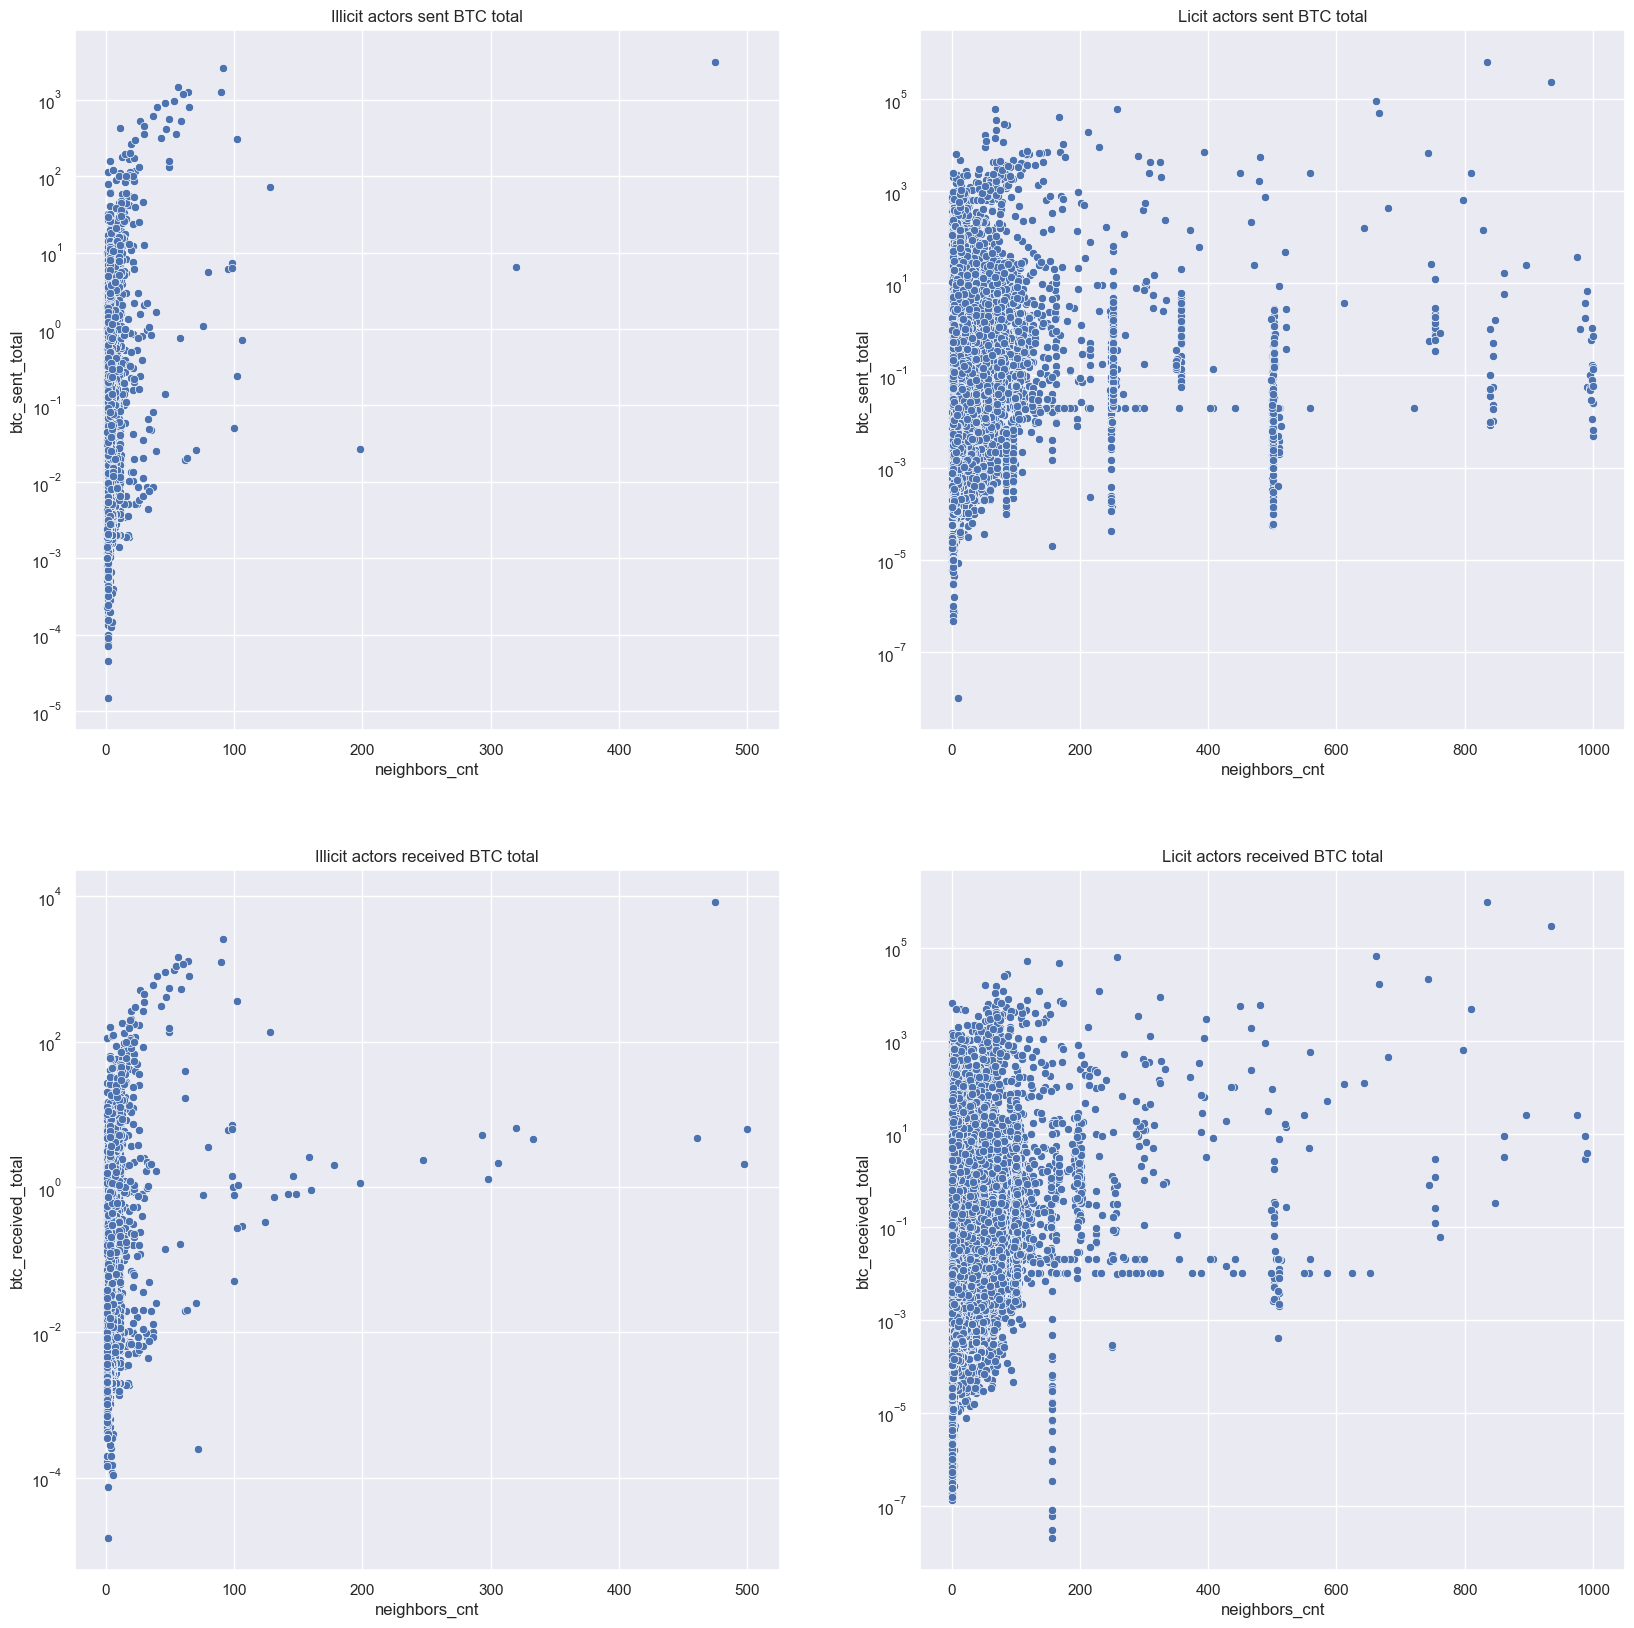

In [161]:
actor_to_nei_and_tx_cnt_with_status_and_money_metrics = pd.merge(
    actor_to_nei_and_tx_cnt_with_status,
    wallets_features[["address", "btc_sent_total", "btc_received_total", "btc_sent_median", "btc_received_median"]],
    left_on="actor_id",
    right_on="address",
    how="left",
)
actor_to_nei_and_tx_cnt_with_status_and_money_metrics.head()

flg, ax = plt.subplots(2, 2, figsize=(20, 20))

sns.scatterplot(
    x="neighbors_cnt",
    y="btc_sent_total",
    data=actor_to_nei_and_tx_cnt_with_status_and_money_metrics[
        (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["class"] == 1) & (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["neighbors_cnt"] <= 1000)
    ],
    ax=ax[0][0]
)
ax[0][0].set_yscale("log")
ax[0][0].set_title("Illicit actors sent BTC total")
sns.scatterplot(
    x="neighbors_cnt",
    y="btc_sent_total",
    data=actor_to_nei_and_tx_cnt_with_status_and_money_metrics[(actor_to_nei_and_tx_cnt_with_status_and_money_metrics["class"] == 2) & (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["neighbors_cnt"] <= 1000)],
    ax=ax[0][1]
)
ax[0][1].set_yscale("log")
ax[0][1].set_title("Licit actors sent BTC total")

sns.scatterplot(
    x="neighbors_cnt",
    y="btc_received_total",
    data=actor_to_nei_and_tx_cnt_with_status_and_money_metrics[
        (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["class"] == 1) & (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["neighbors_cnt"] <= 1000)
    ],
    ax=ax[1][0]
)
ax[1][0].set_yscale("log")
ax[1][0].set_title("Illicit actors received BTC total")
sns.scatterplot(
    x="neighbors_cnt",
    y="btc_received_total",
    data=actor_to_nei_and_tx_cnt_with_status_and_money_metrics[(actor_to_nei_and_tx_cnt_with_status_and_money_metrics["class"] == 2) & (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["neighbors_cnt"] <= 1000)],
    ax=ax[1][1]
)
ax[1][1].set_yscale("log")

ax[1][1].set_title("Licit actors received BTC total")

Text(0.5, 1.0, 'Licit actors received BTC total')

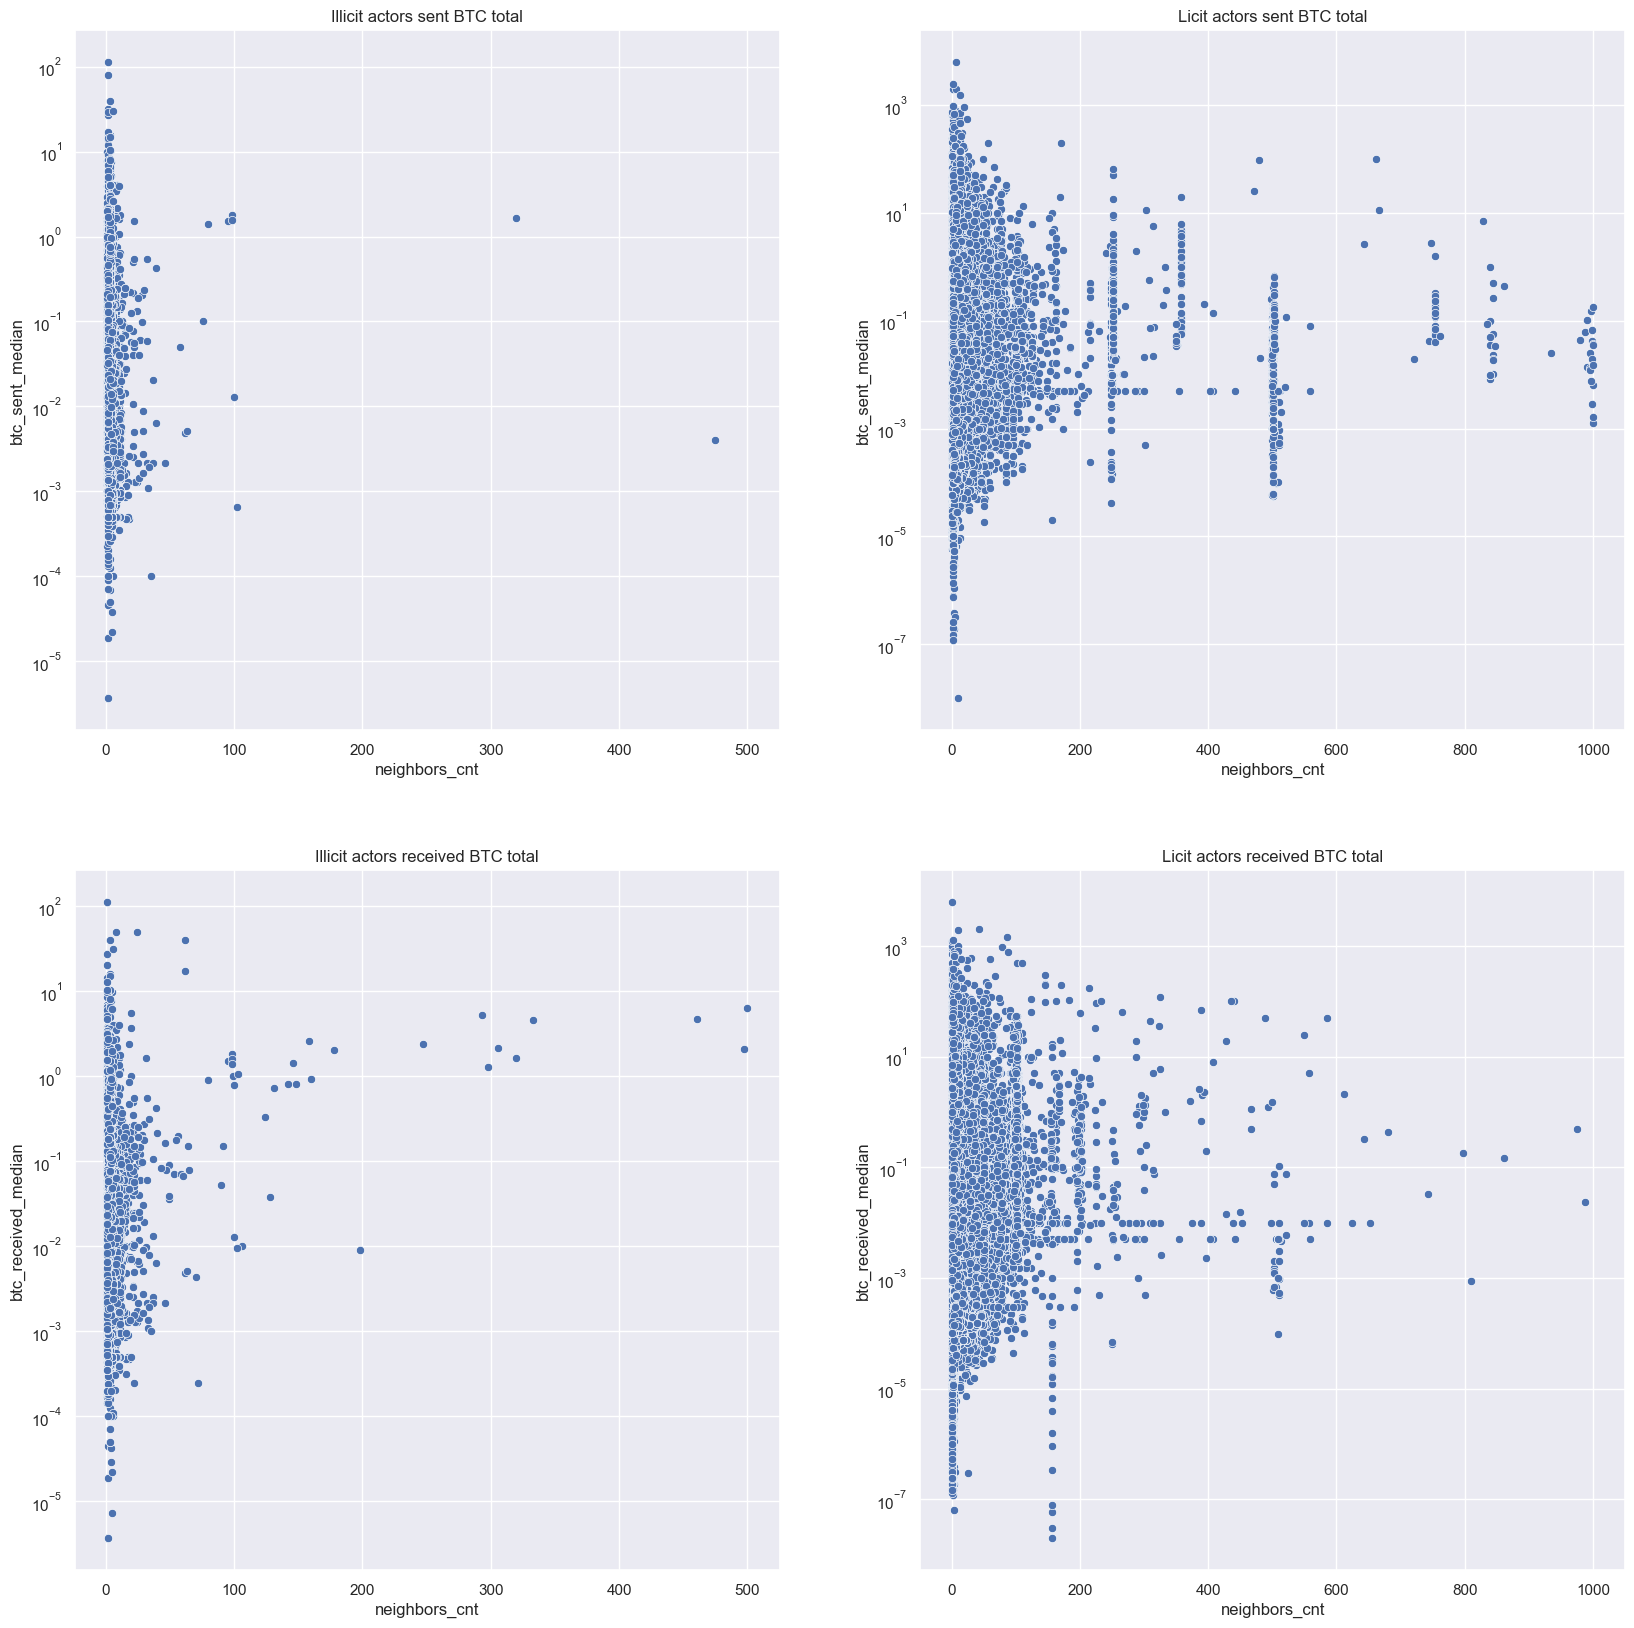

In [162]:

flg, ax = plt.subplots(2, 2, figsize=(20, 20))

sns.scatterplot(
    x="neighbors_cnt",
    y="btc_sent_median",
    data=actor_to_nei_and_tx_cnt_with_status_and_money_metrics[
        (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["class"] == 1) & (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["neighbors_cnt"] <= 1000)
    ],
    ax=ax[0][0]
)
ax[0][0].set_yscale("log")
ax[0][0].set_title("Illicit actors sent BTC total")
sns.scatterplot(
    x="neighbors_cnt",
    y="btc_sent_median",
    data=actor_to_nei_and_tx_cnt_with_status_and_money_metrics[(actor_to_nei_and_tx_cnt_with_status_and_money_metrics["class"] == 2) & (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["neighbors_cnt"] <= 1000)],
    ax=ax[0][1]
)
ax[0][1].set_yscale("log")
ax[0][1].set_title("Licit actors sent BTC total")

sns.scatterplot(
    x="neighbors_cnt",
    y="btc_received_median",
    data=actor_to_nei_and_tx_cnt_with_status_and_money_metrics[
        (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["class"] == 1) & (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["neighbors_cnt"] <= 1000)
    ],
    ax=ax[1][0]
)
ax[1][0].set_yscale("log")
ax[1][0].set_title("Illicit actors received BTC total")
sns.scatterplot(
    x="neighbors_cnt",
    y="btc_received_median",
    data=actor_to_nei_and_tx_cnt_with_status_and_money_metrics[(actor_to_nei_and_tx_cnt_with_status_and_money_metrics["class"] == 2) & (actor_to_nei_and_tx_cnt_with_status_and_money_metrics["neighbors_cnt"] <= 1000)],
    ax=ax[1][1]
)
ax[1][1].set_yscale("log")

ax[1][1].set_title("Licit actors received BTC total")